# Test 1 on kepler data 

Test 1 on Kepler data aims to examine the performance of a random forest also considering the follow-up characteristics

In [1]:
import pandas as pd
import sys
import os

# Added paths to import modules
sys.path.insert(0, os.path.abspath('../'))

# import custom modules
from data_processing.distribution import (plot_class_distribution, plot_feature_importances,
                                          plot_scatter_feature_distributions, 
                                          plot_hist_feature_distributions,
                                          plot_hist_feature_distributions_0_1,
                                          compute_train_0_1)
from data_processing.data_analysis import (compute_all_columns_nan, print_nan_numbers_for_features,
                                           threshold_delete_nan)
from data_processing.data_scaling import plot_top_7_difference, data_scaling_normalization
from data_processing.features_prosessing import remove_non_numeric_columns, rows_id_nan
from data_processing.knn_imputer import k_nearest_neighbors_imputer
from data_processing.replace_disposition import replace_label
from dimensionality_reduction.features_selection import compute_feature_importance, feature_selection_rfc
from model_selection.grid_search import grid_search_param_optimization
from utils.mission import Mission
from utils.plot_style import PlotStyle
from utils.util import print_count_nan, print_feature_importance

# Read Data

read the csv file taken from:
1. Kepler: NASA Exoplanet Archive  http://exoplanetarchive.ipac.caltech.edu

In [2]:
kepler_data = pd.read_csv('../data/raw_data/cumulative_2023.11.04_08.48.13.csv')
print('Shape of Kepler Cumulative KOI', kepler_data.shape)
_ = print_count_nan(data=kepler_data, name='Kepler Cumulative KOI')

Shape of Kepler Cumulative KOI (9564, 141)
Number of NaN values in Kepler Cumulative KOI: 237116 out of 1348524: 17.58%


# Replace Label

In the data initially there is an disposition that includes 3 or more classes.

Kepler:
1. CONFIRMED
2. CANDIDATE
3. FALSE POSITIVE

with the aim of making a binary classifier we use the following procedure to replace:
1. CONFIRMED, CANDIDATE with the label: 1
2. FALSE POSITIVE with the label: 0

In [3]:
kepler_data = replace_label(data=kepler_data, mission=Mission.KEPLER)
print('Shape of kepler data: ', kepler_data.shape)

Shape of kepler data:  (9564, 141)


# Feature and Label Processing

The Kepler and TESS data have different features, so we want to find an intersection between the two sets of data. To do this, we perform several operations:

1. Removing non-numeric features
2. Removing of identifying and follow-up characteristics
3. Identifying the labels (X_train, y_train)
4. Removing NaN in y_train and correspondingly also the X_train rows (if there are)

In [4]:
kepler_data, non_numeric_columns = remove_non_numeric_columns(df=kepler_data)
print('Non numric columns removed:', non_numeric_columns)

Non numric columns removed: ['kepoi_name', 'kepler_name', 'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_disp_prov', 'koi_comment', 'koi_fittype', 'koi_limbdark_mod', 'koi_parm_prov', 'koi_tce_delivname', 'koi_quarters', 'koi_trans_mod', 'koi_datalink_dvr', 'koi_datalink_dvs', 'koi_sparprov']


In [5]:
columns_to_remove = ['rowid','kepid']
kepler_data = kepler_data.drop(columns=columns_to_remove)

In [6]:
y_train = kepler_data['koi_disposition']
kepler_data = kepler_data.drop(columns='koi_disposition')
X_train = kepler_data

In [7]:
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)
_ = print_count_nan(data=y_train, name='y_train')

Shape of X_train data:  (9564, 122)
Shape of y_train data:  (9564,)
Number of NaN values in y_train: 0 out of 9564: 0.00%


# Data Scaling

Nonostante non costituisca un prerequisito necessario nei modelli di machine learning, il processo di normalizzare i dati è tipicamente impiegato con l'obiettivo di:

1. Standardizzare l'intervallo di valori di tutte le caratteristiche del dataset
2. Migliorare la robustezza numerica degli algoritmi impiegati.

Per fare ciò viene utilizzato un modulo di scikit-learn StandardScaler il quale vuole standardizzare le caratteristiche rimuovendo la media e ridimensionandole alla varianza unitaria. Il punteggio standard di un campione x viene calcolato come:

$$
z = \frac{x - \mu}{\sigma}
$$

dove $\mu$ è la media dei campioni di addestramento o zero se with_mean=False, e $\sigma$ è la deviazione standard dei campioni di addestramento o uno se with_std=False.

La standardizzazione induce una variabile aleatoria distribuita secondo una media $\mu$ e varianza $\sigma^2$, ad una variabile aleatoria con distribuzione "standard", ossia di media zero e varianza unitaria.

Plot Before the scaling


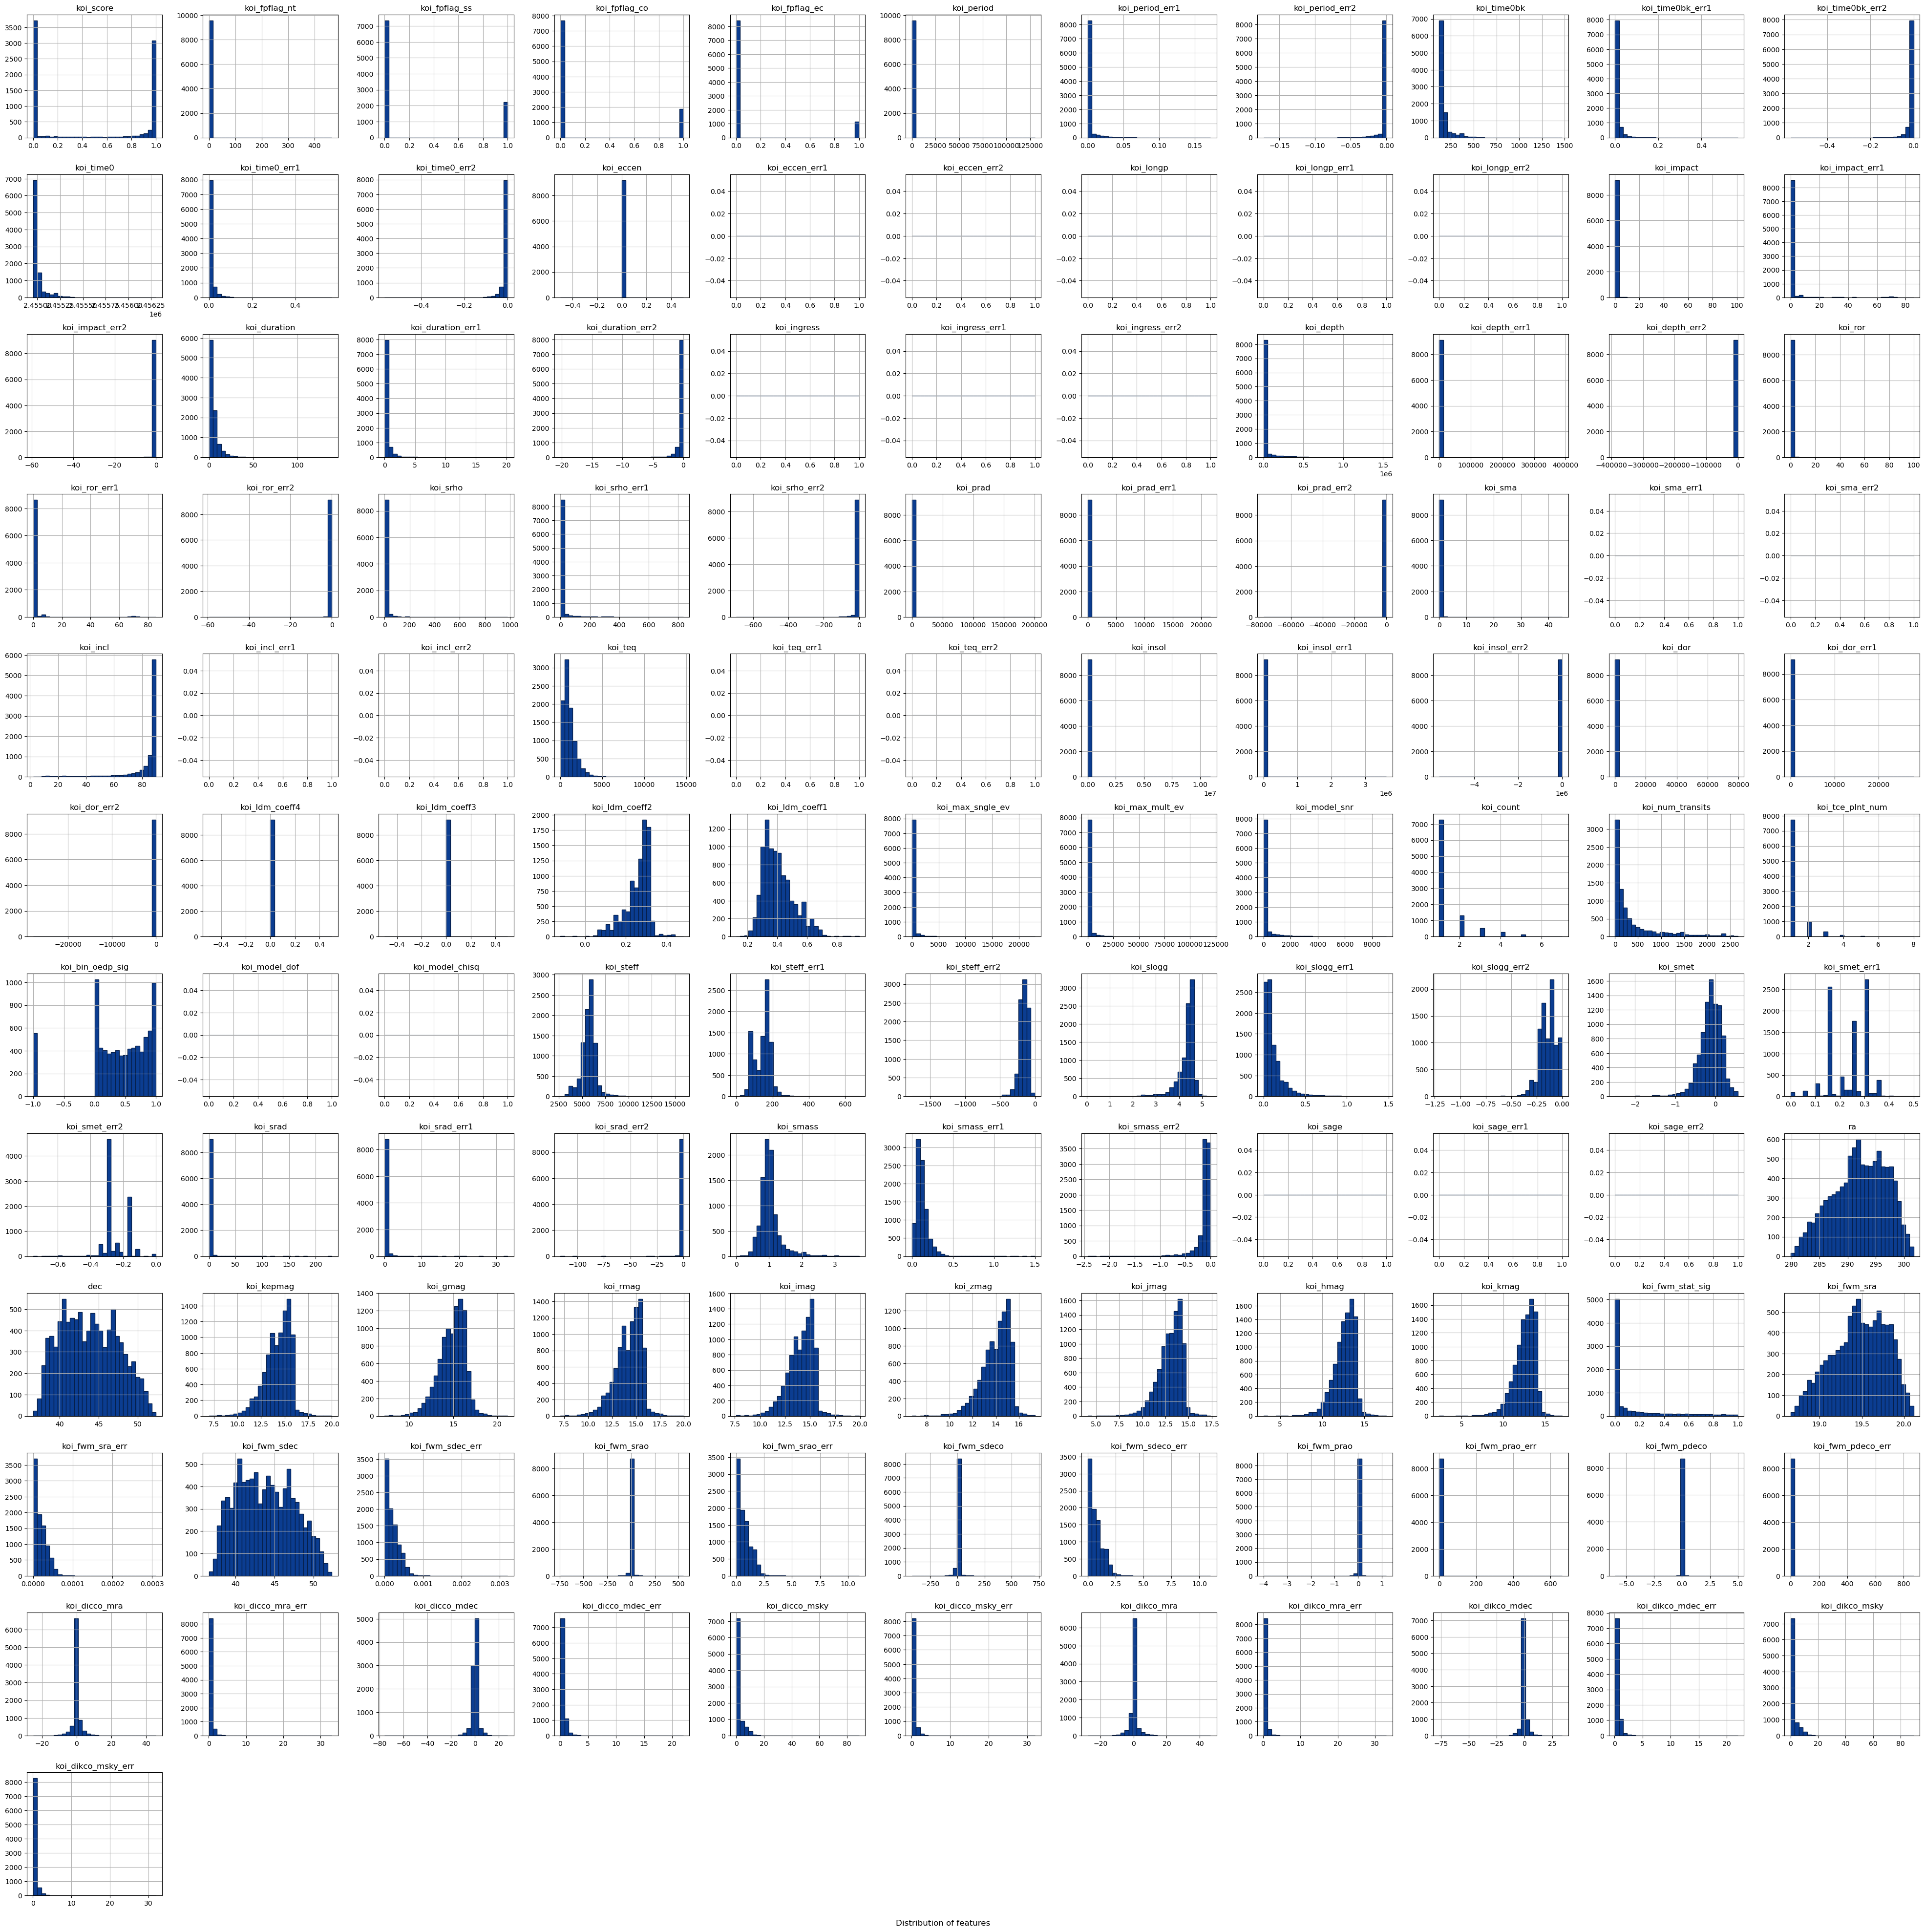

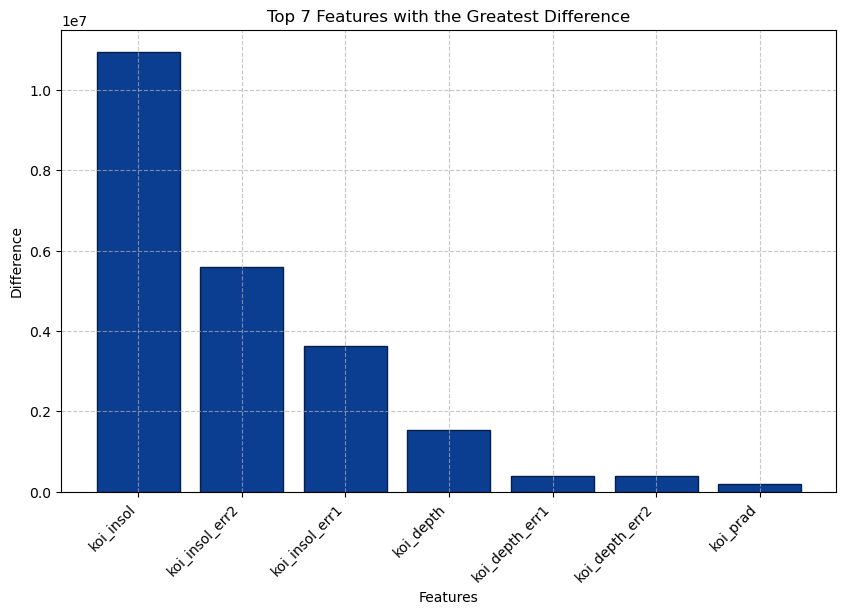

In [8]:
print('Plot Before the scaling')
plot_hist_feature_distributions(X_train=X_train)
plot_top_7_difference(X_train=X_train)

In [9]:
X_train = data_scaling_normalization(X_train=X_train, with_mean=True,
                                     with_std=True, print_mean_scale=False)

/home/a.divicino/miniconda3/envs/env_tesi/lib/python3.8/site-packages/sklearn/utils/extmath.py:1050: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/a.divicino/miniconda3/envs/env_tesi/lib/python3.8/site-packages/sklearn/utils/extmath.py:1055: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/a.divicino/miniconda3/envs/env_tesi/lib/python3.8/site-packages/sklearn/utils/extmath.py:1075: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


# K-Nearest Neighbors

The NaN problem must be managed carefully, there are several solutions that can be used, one of these is the KNN methodology which calculates a distance (e.g. Euclidean or Manhattan) between the observations and calculates the new value to be inserted with some methodologies (e.g. IDWM or IRWM) but considering the nearest K, where K is defined a priori, generally for K the square root of N is considered where N is the number of observations, or an approximation is used.

In this case, for efficiency reasons, the sklearn KNNImputer module was used which is optimized.

In [10]:
_ = print_count_nan(data=X_train, name='X_train')

Number of NaN values in X_train: 225817 out of 1166808: 19.35%


In [11]:
# Calculate columns that contain only nan and the number of nan for each columns
nan_columns = compute_all_columns_nan(data=X_train)
number_of_nan_columns = {col: X_train[col].isna().sum() for col in X_train}
number_of_nan_columns = dict(sorted(number_of_nan_columns.items(), key=lambda x: x[1], reverse=True))
print_nan_numbers_for_features(data=X_train, number_of_nan_columns=number_of_nan_columns)

Columns containing only not a number in X_train: ['koi_eccen_err1', 'koi_eccen_err2', 'koi_longp', 'koi_longp_err1', 'koi_longp_err2', 'koi_ingress', 'koi_ingress_err1', 'koi_ingress_err2', 'koi_sma_err1', 'koi_sma_err2', 'koi_incl_err1', 'koi_incl_err2', 'koi_teq_err1', 'koi_teq_err2', 'koi_model_dof', 'koi_model_chisq', 'koi_sage', 'koi_sage_err1', 'koi_sage_err2']
Number of Observations: 9564
NaN for each feature
  1: koi_eccen_err1----------------> 9564
  2: koi_eccen_err2----------------> 9564
  3: koi_longp---------------------> 9564
  4: koi_longp_err1----------------> 9564
  5: koi_longp_err2----------------> 9564
  6: koi_ingress-------------------> 9564
  7: koi_ingress_err1--------------> 9564
  8: koi_ingress_err2--------------> 9564
  9: koi_sma_err1------------------> 9564
 10: koi_sma_err2------------------> 9564
 11: koi_incl_err1-----------------> 9564
 12: koi_incl_err2-----------------> 9564
 13: koi_teq_err1------------------> 9564
 14: koi_teq_err2-----------------

In [12]:
TCOL = 600
nan_columns = threshold_delete_nan(number_of_nan_columns=number_of_nan_columns,
                                        nan_columns_name=nan_columns, threshold=TCOL)
X_train = X_train.drop(columns=nan_columns)
_ = print_count_nan(data=X_train, name='X_train')
print('Shape of X_train:', X_train.shape)

Number of NaN values in X_train: 32672 out of 879888: 3.71%
Shape of X_train: (9564, 92)


In [13]:
# Compute the number of not a number for each rows
number_of_nan_rows = X_train.isna().sum(axis=1)
TROW = 10
id_rows = rows_id_nan(number_of_nan_rows=number_of_nan_rows,
                      X_train=X_train, threshold=TROW)

Total rows >= of T=10: 956 out of a total of 9564 By eliminating them you obtain 8608 observations


In [14]:
# Drop rows >= T
X_train = X_train.drop(id_rows).reset_index(drop=True)
y_train = y_train.drop(id_rows).reset_index(drop=True)
print('Shape of X_train:', X_train.shape)
_ = print_count_nan(data=X_train, name='X_train')

Shape of X_train: (8608, 92)
Number of NaN values in X_train: 1616 out of 791936: 0.20%


In [15]:
INDEX_OF_K = 10
# Using KNNImputer
X_train = k_nearest_neighbors_imputer(X_train=X_train, index_of_k=INDEX_OF_K)
count = X_train.isna().sum()
print('Number of not a number in X_train is:', count.sum())
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)

Number of NaN values in X_train: 1616 out of 791936: 0.20%
Number of not a number in X_train is: 0
Shape of X_train data:  (8608, 92)
Shape of y_train data:  (8608,)


Plot After the scaling and KNNImputer


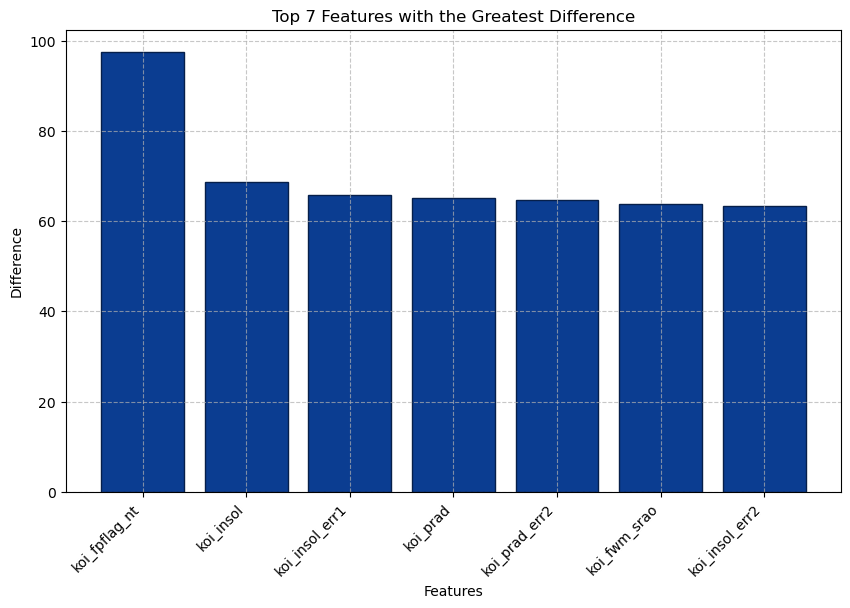

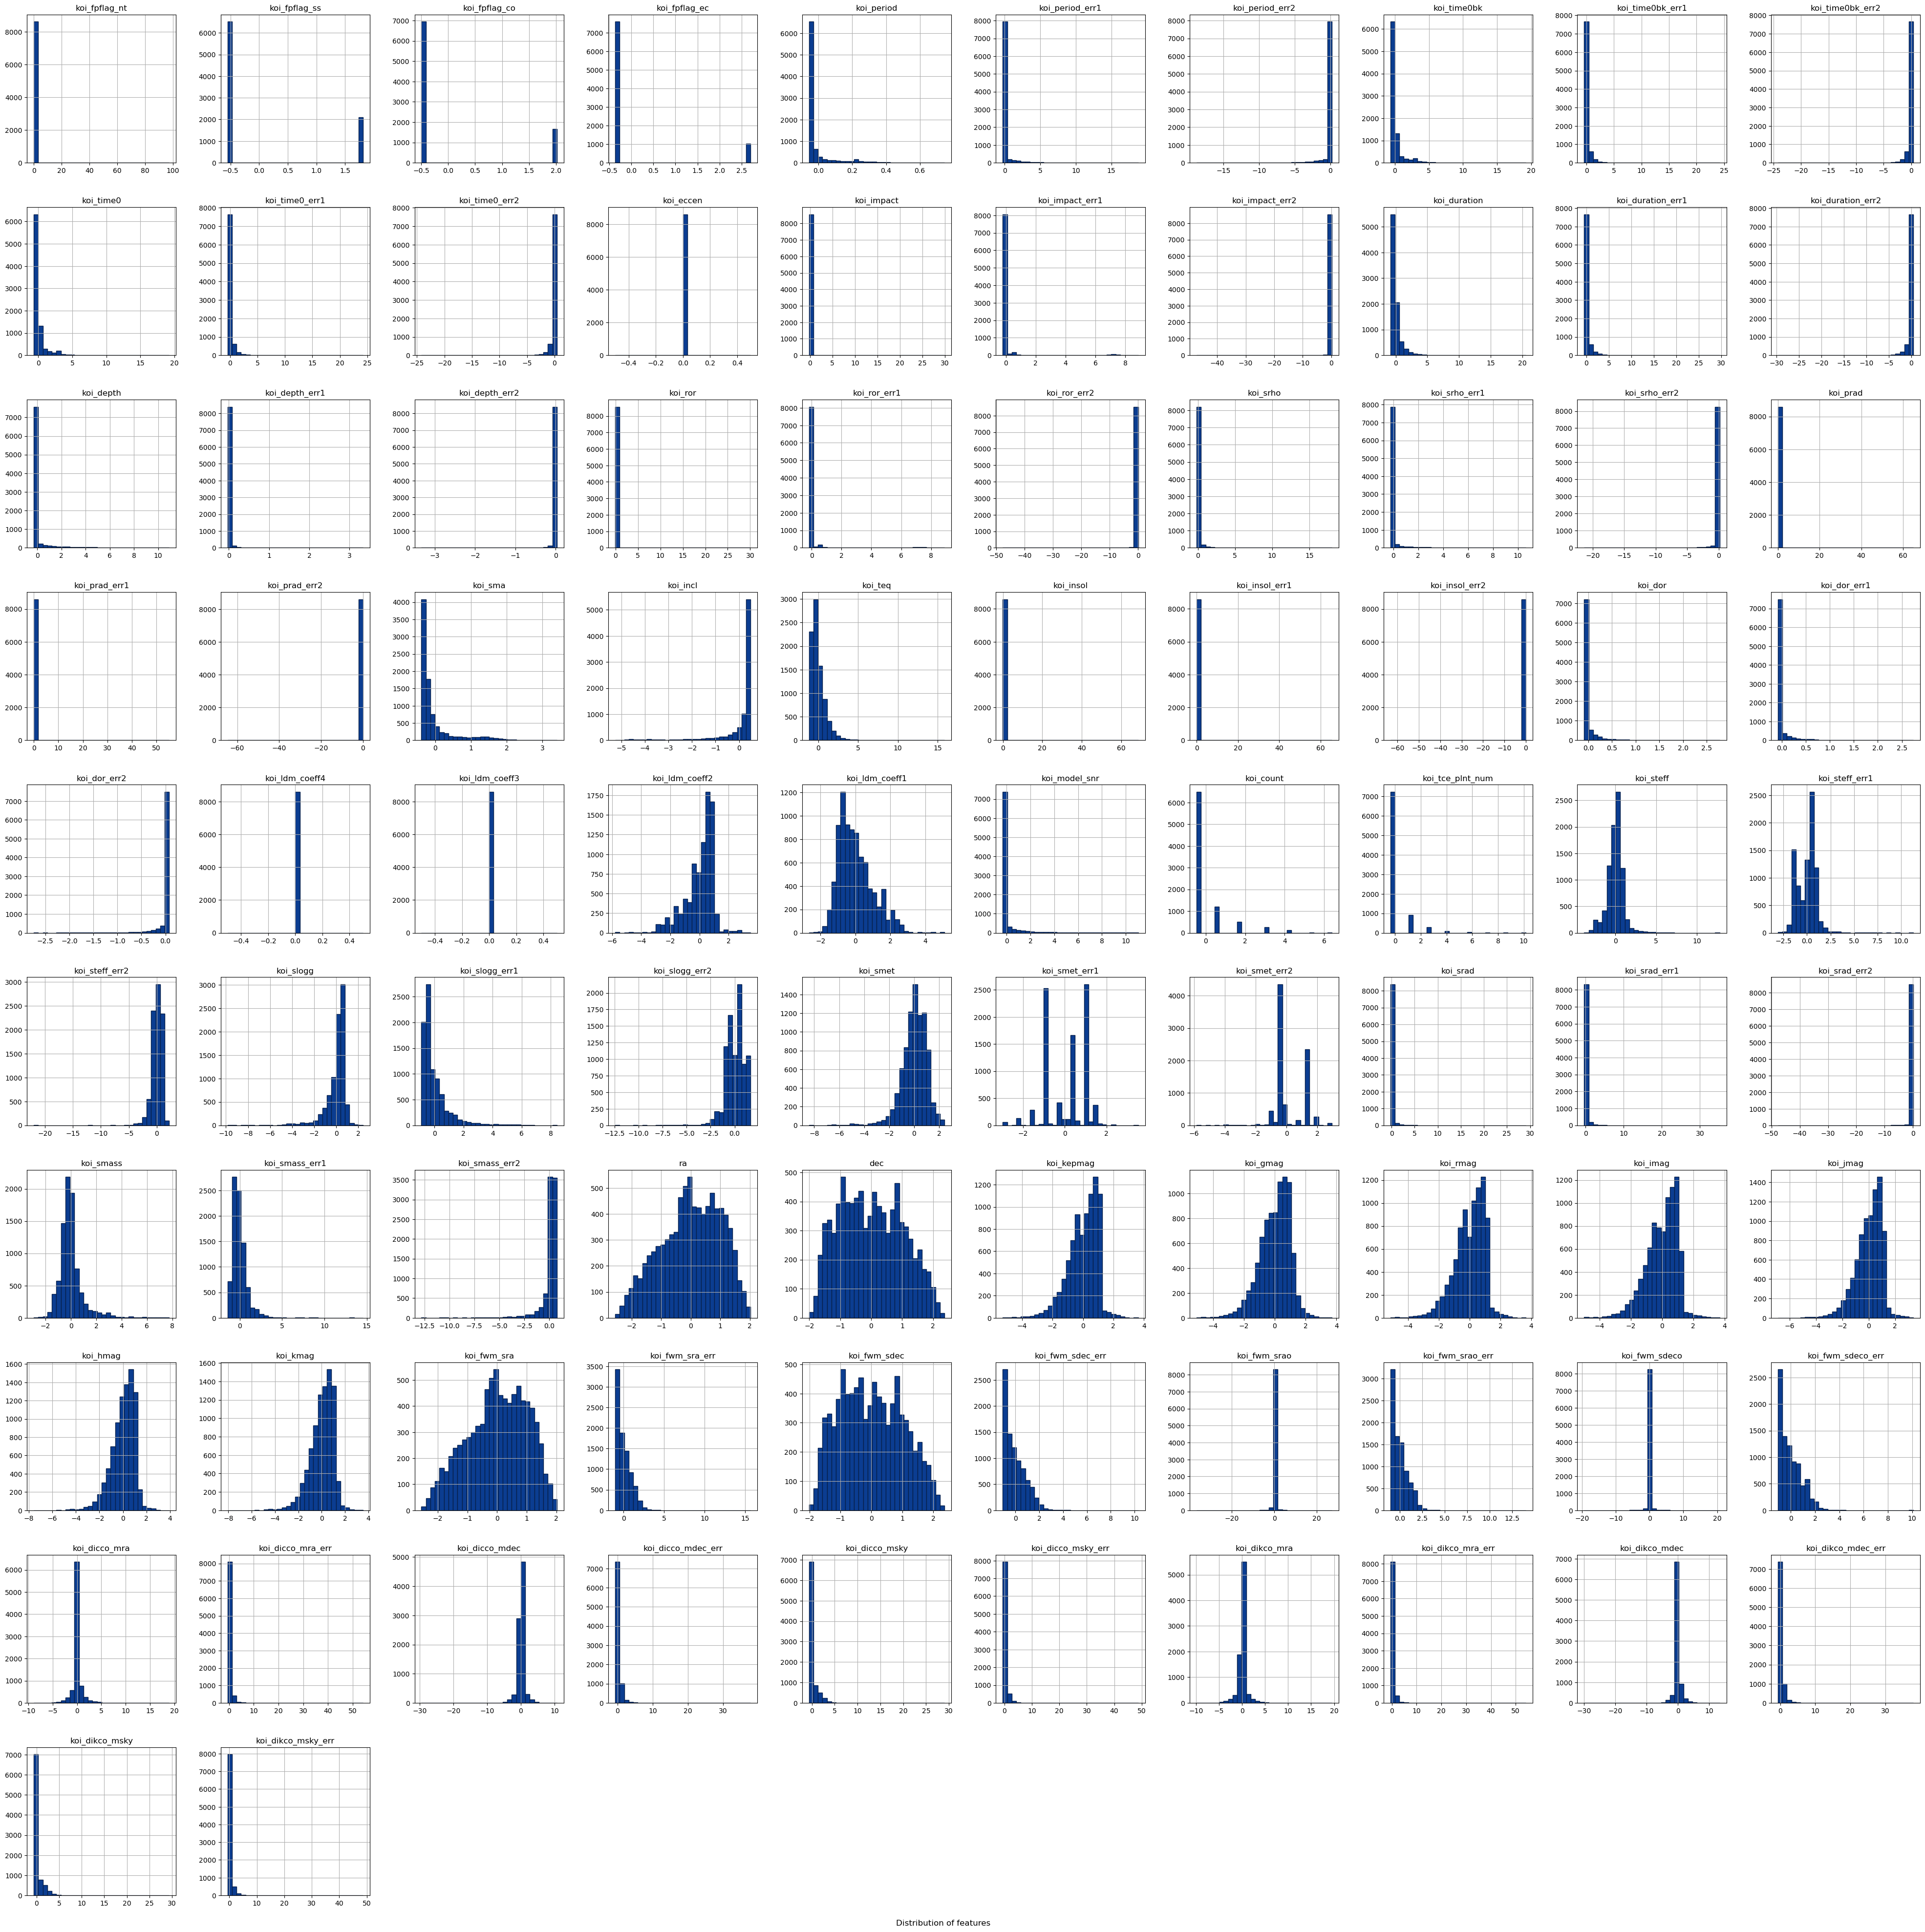

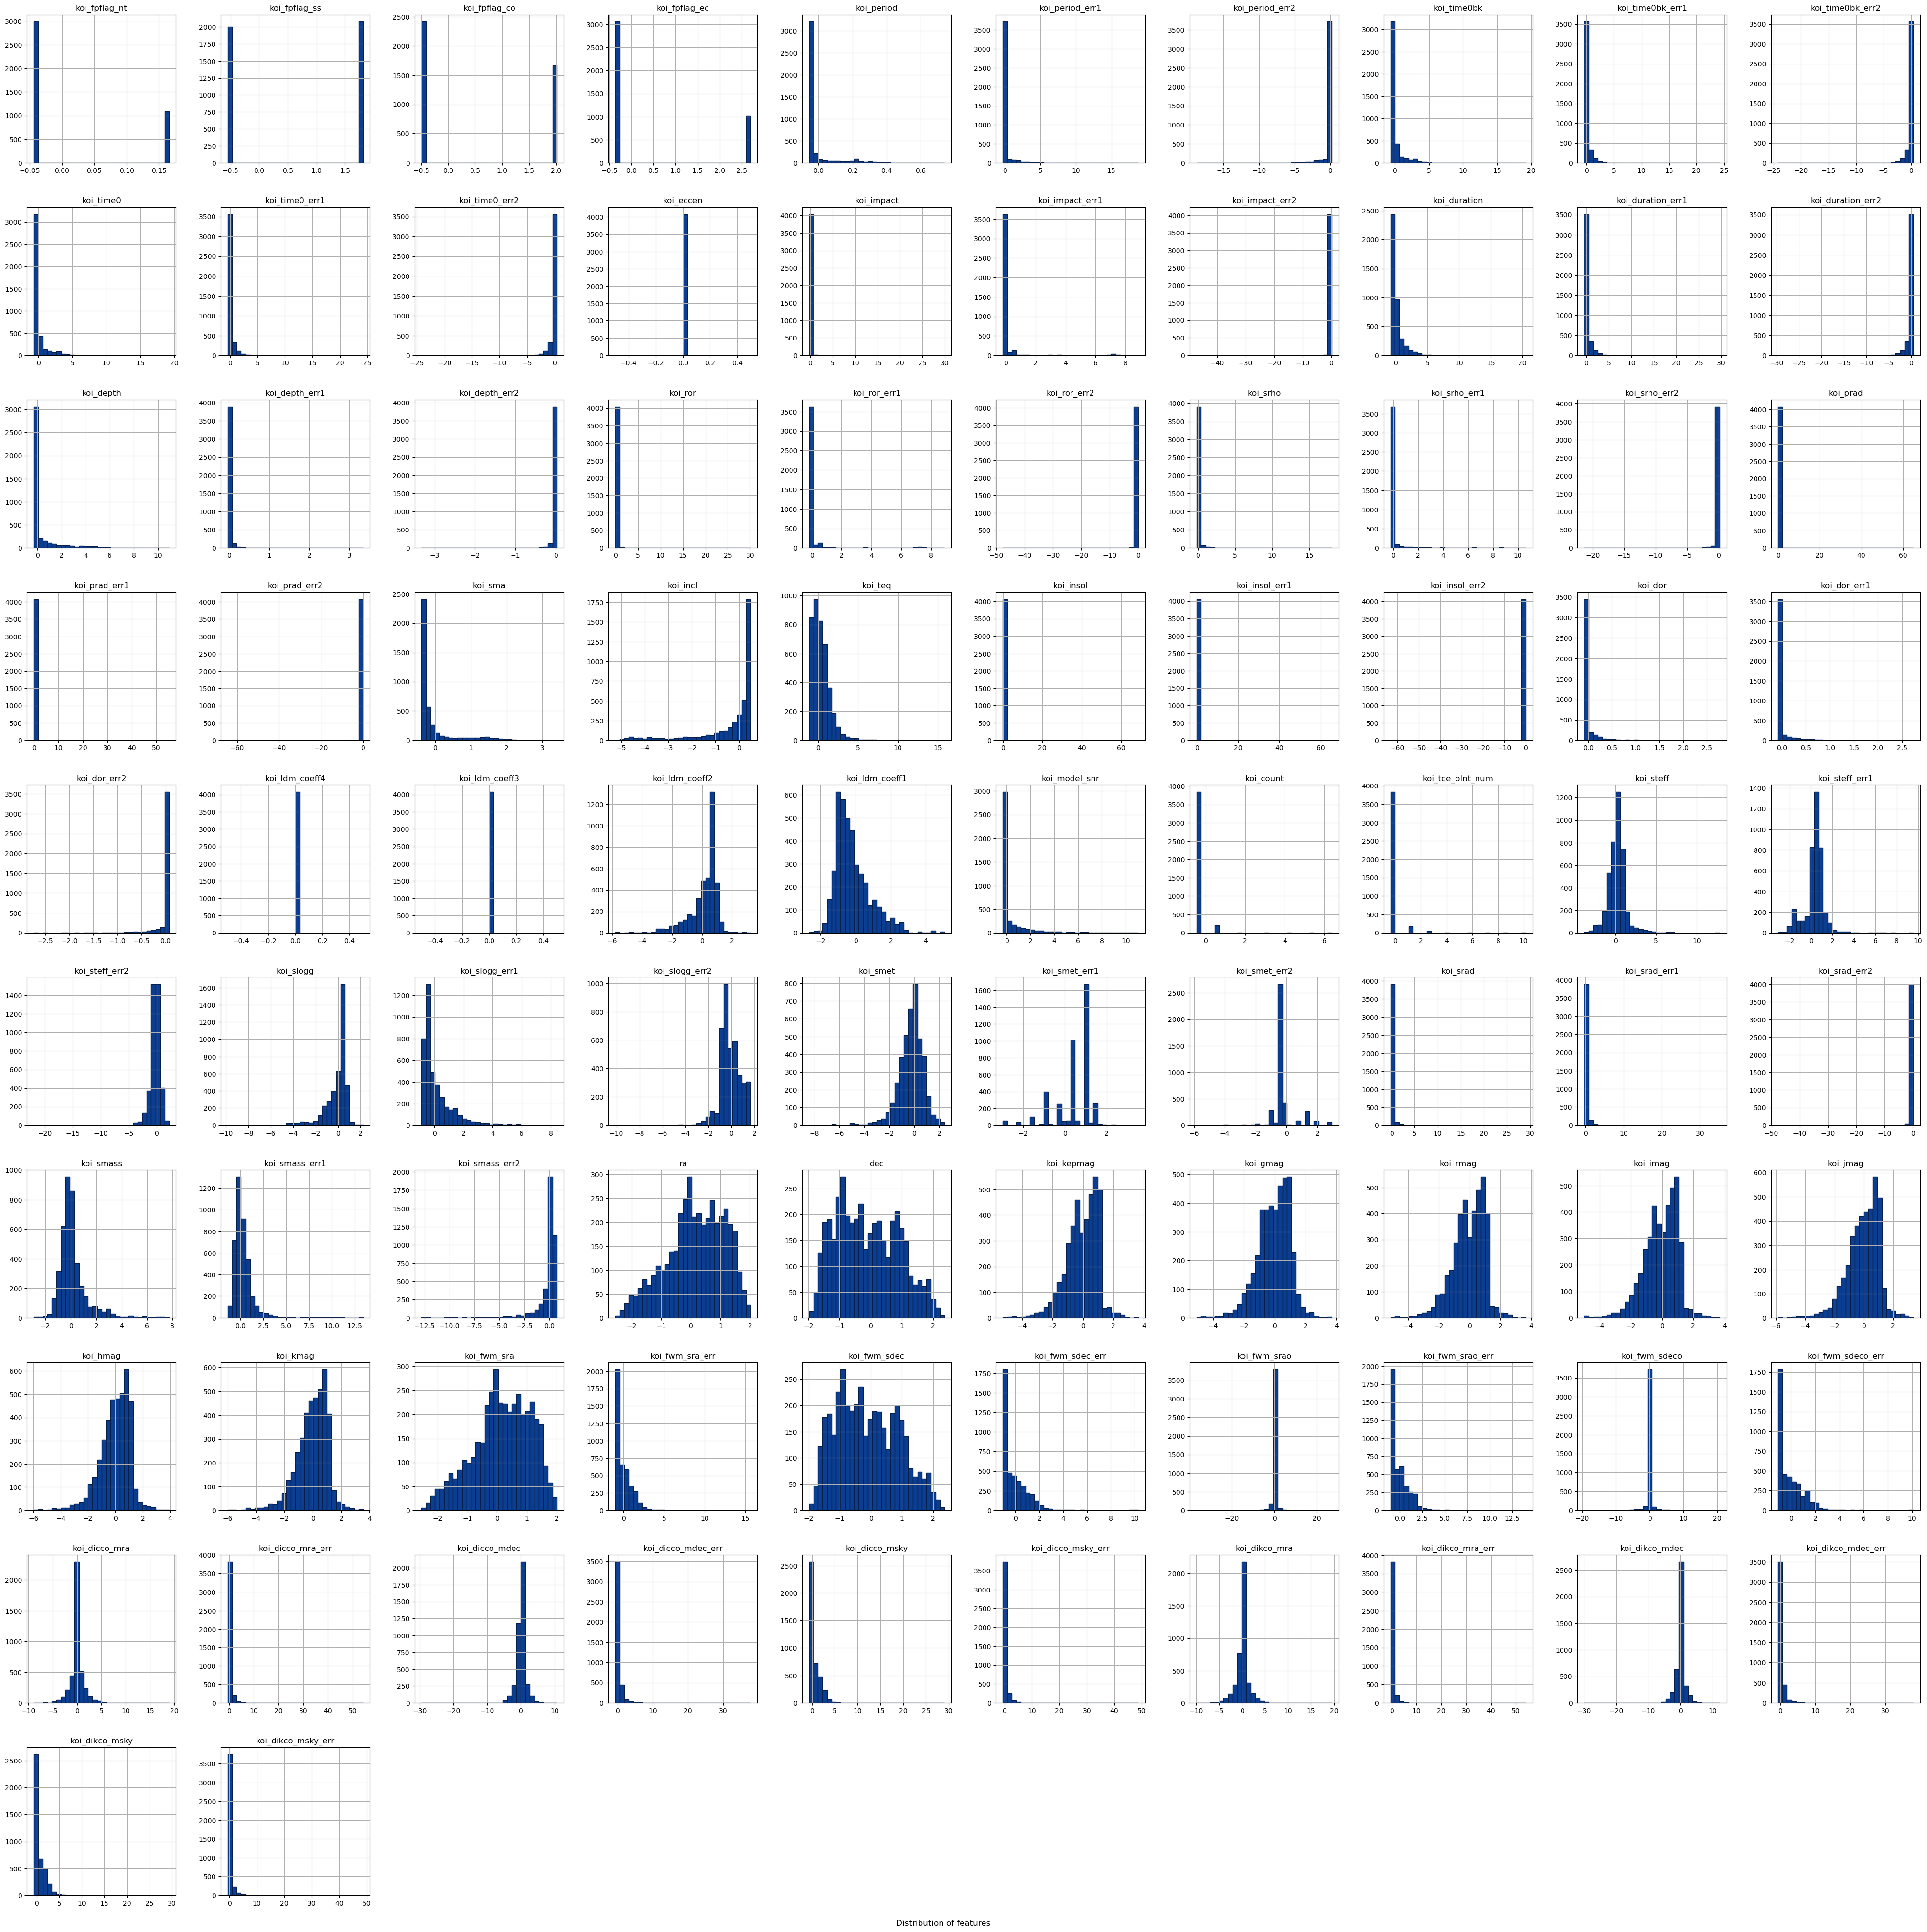

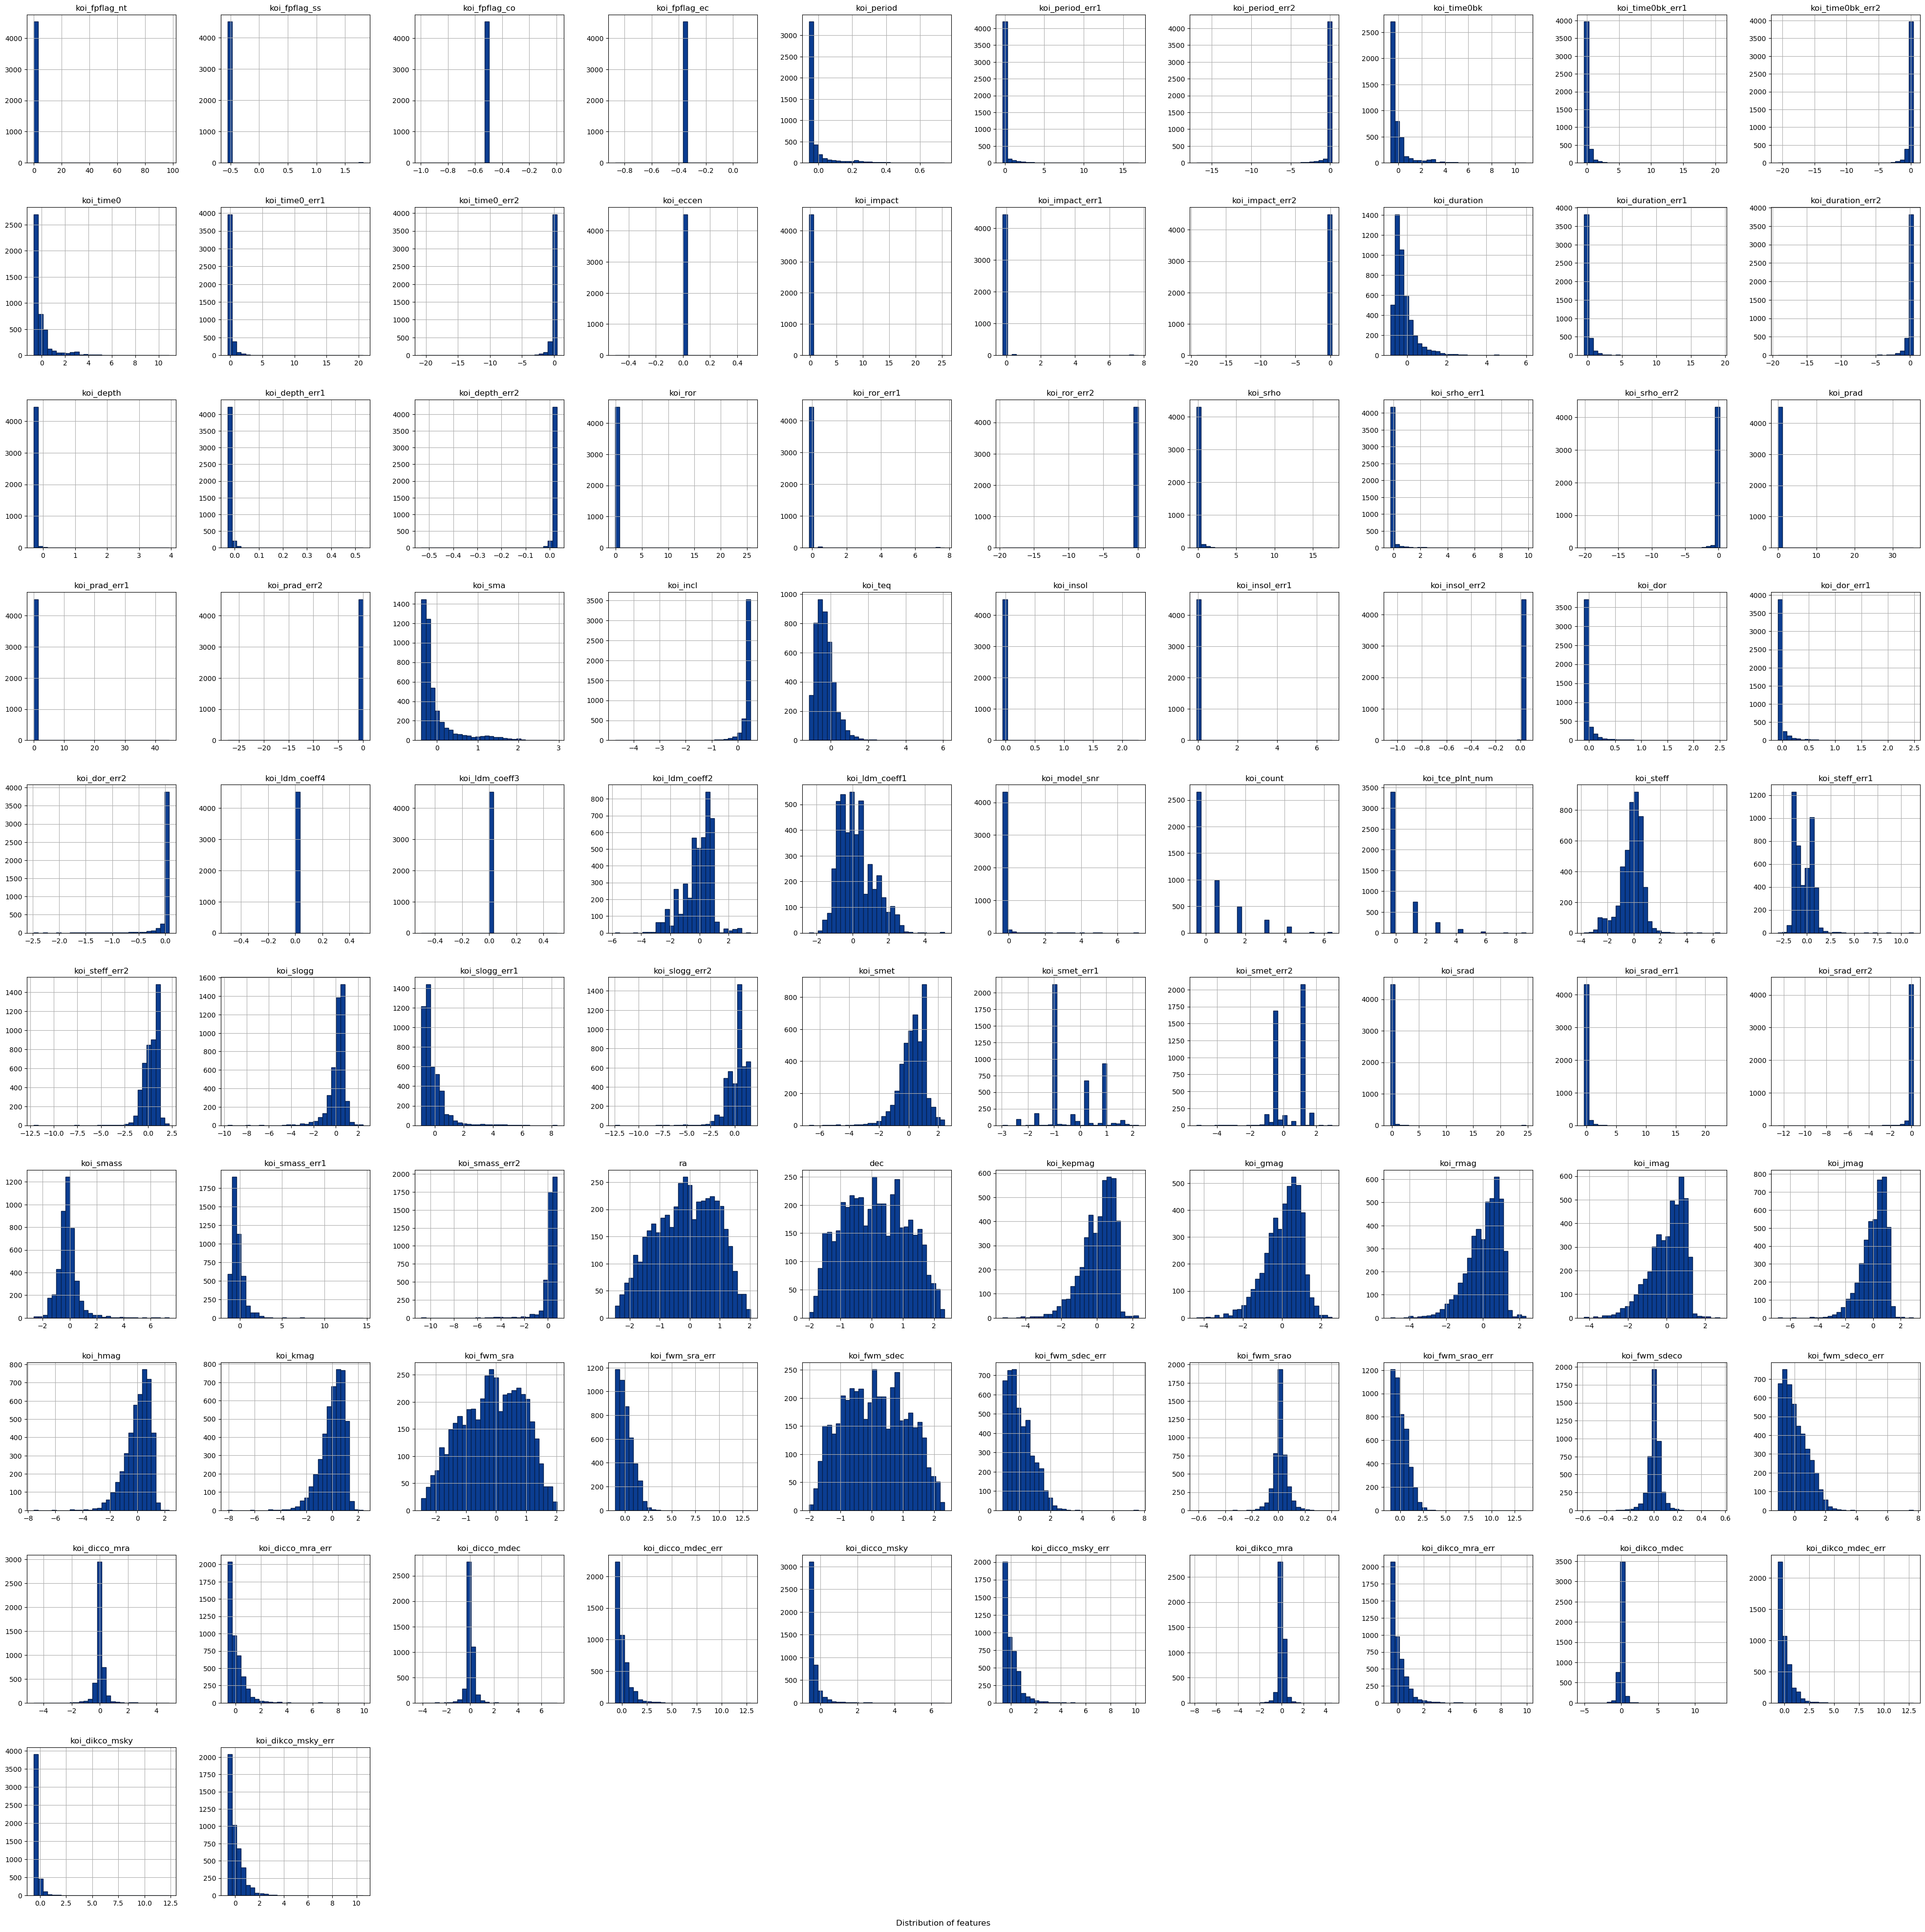

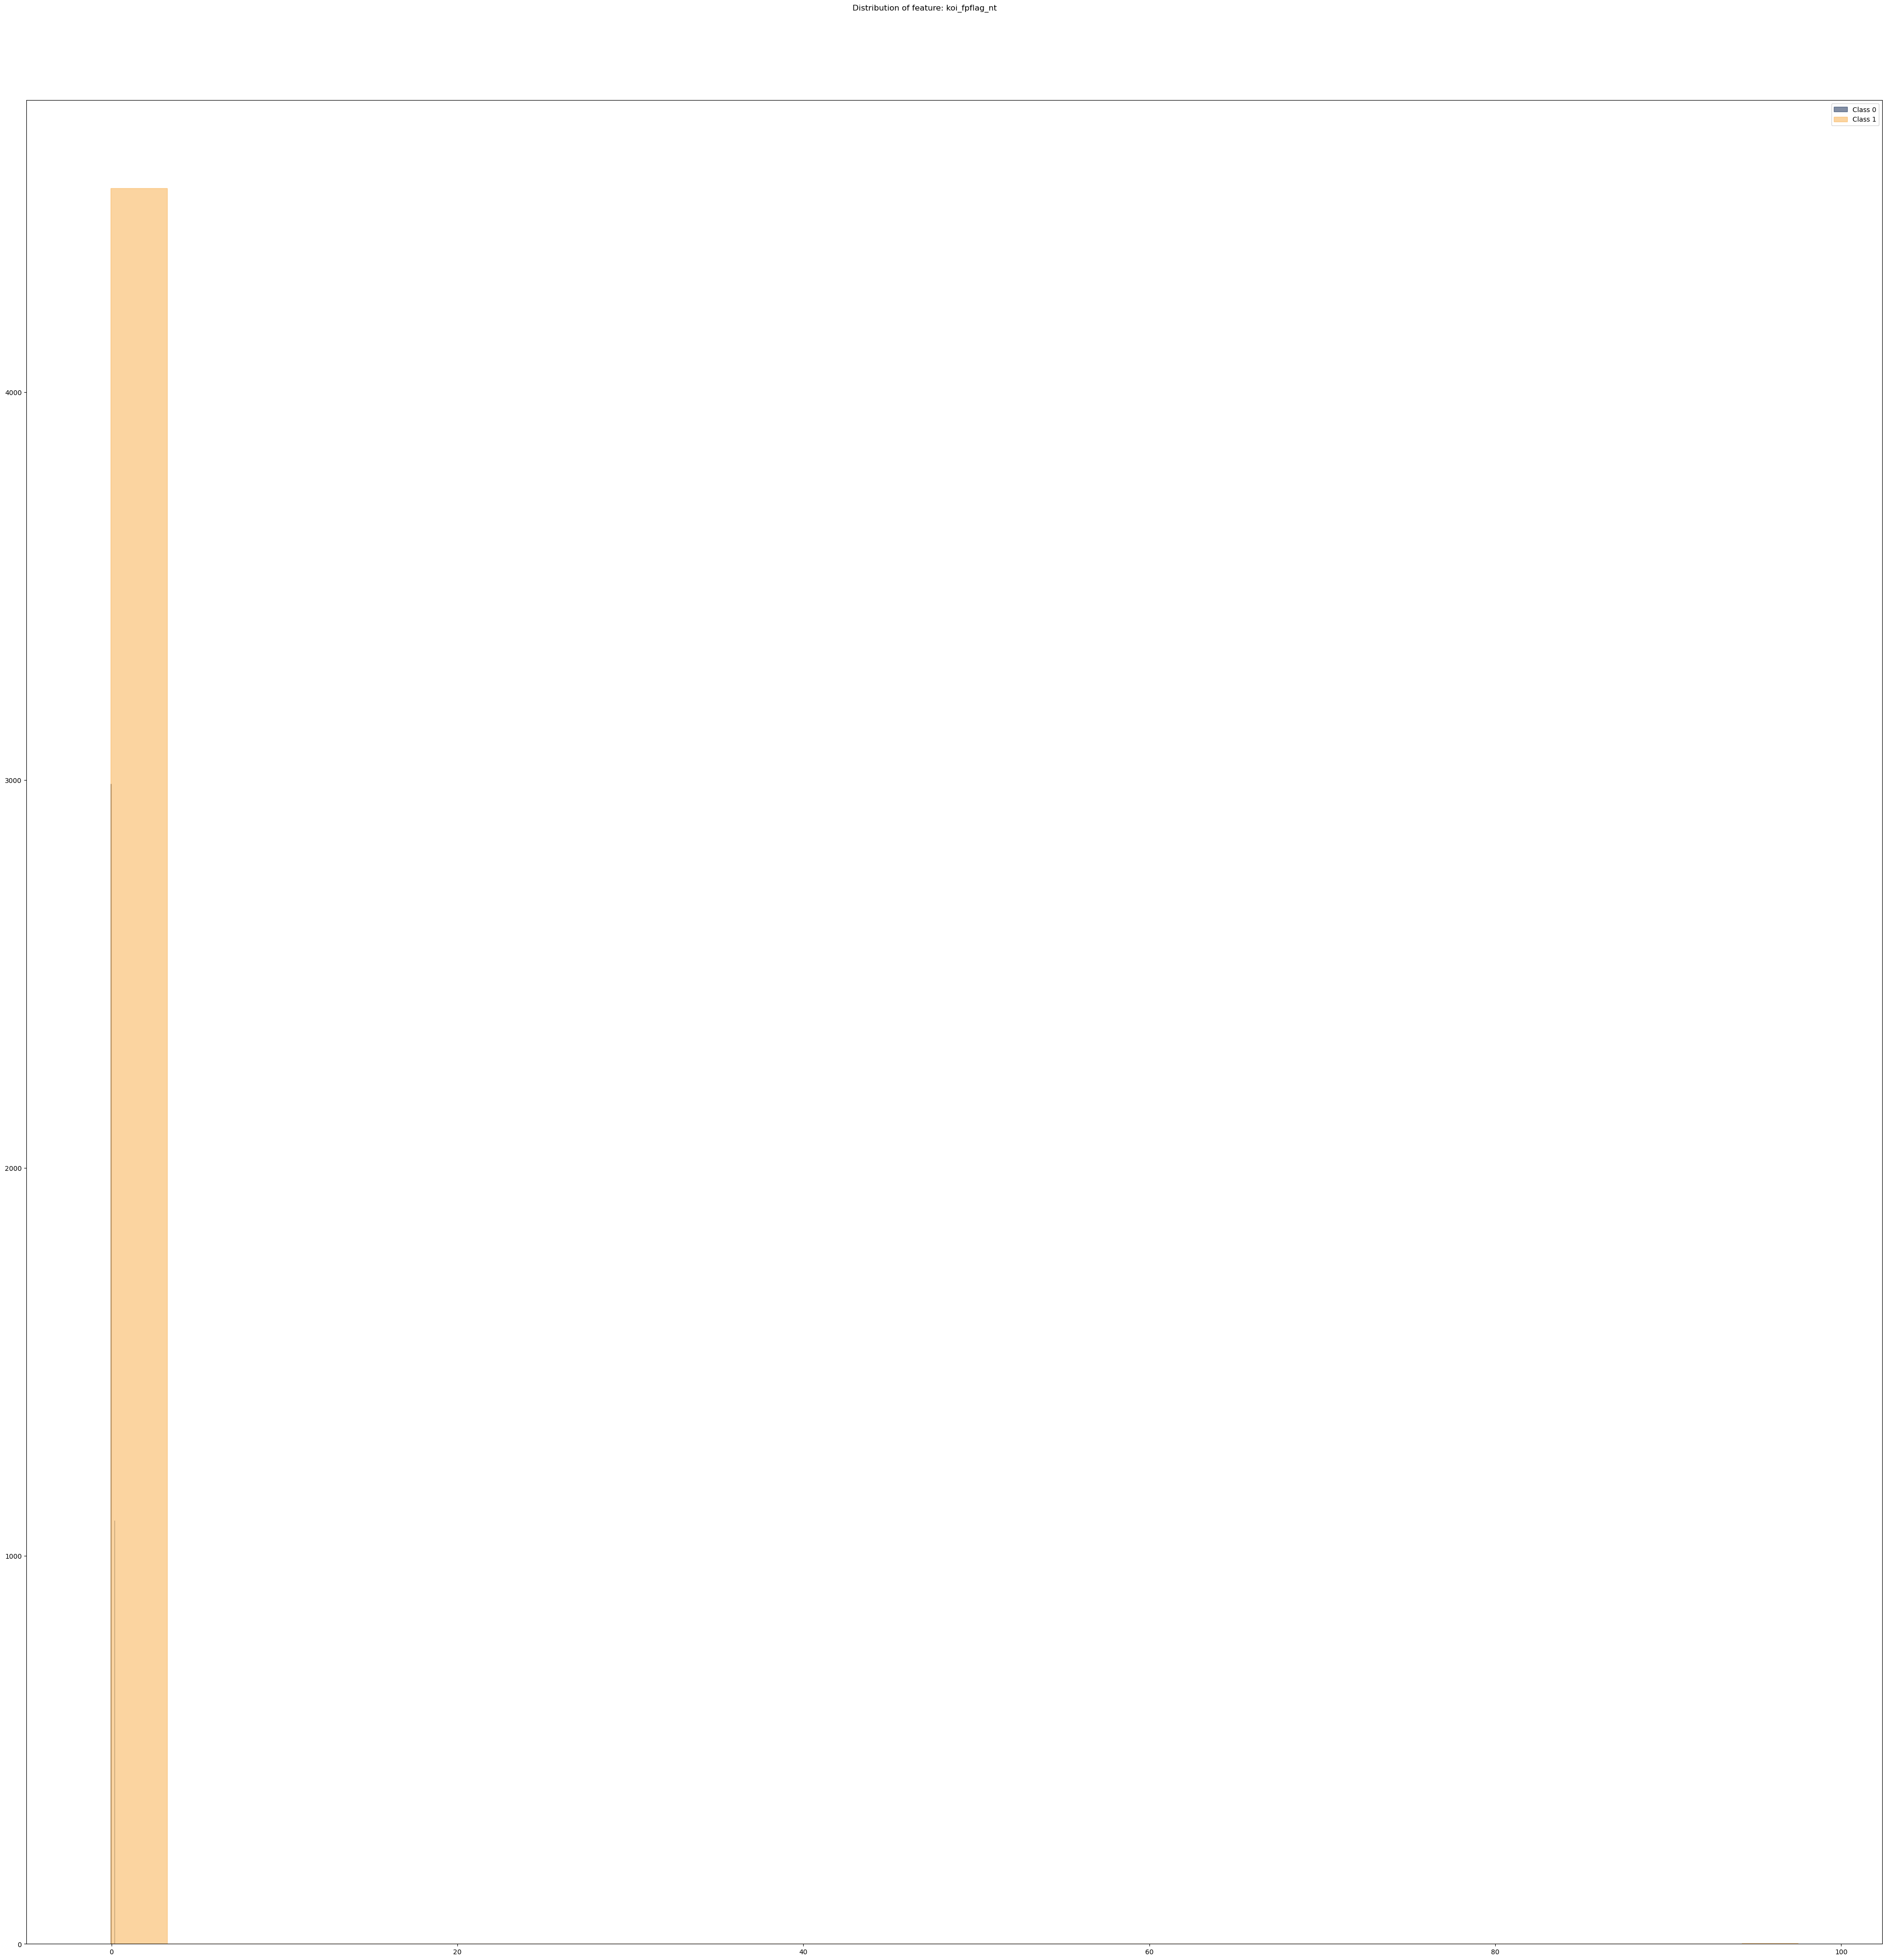

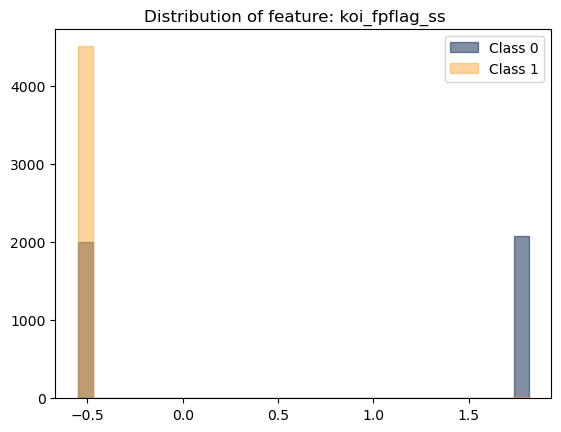

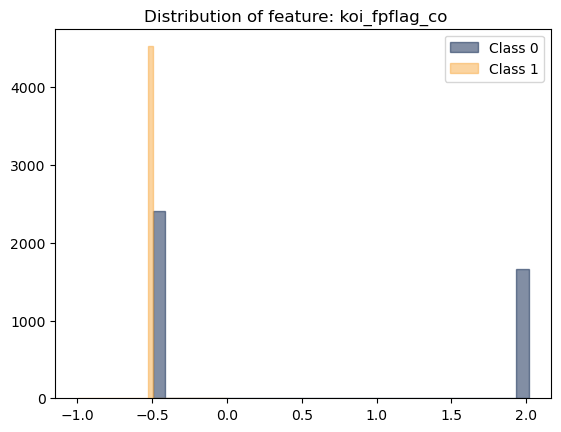

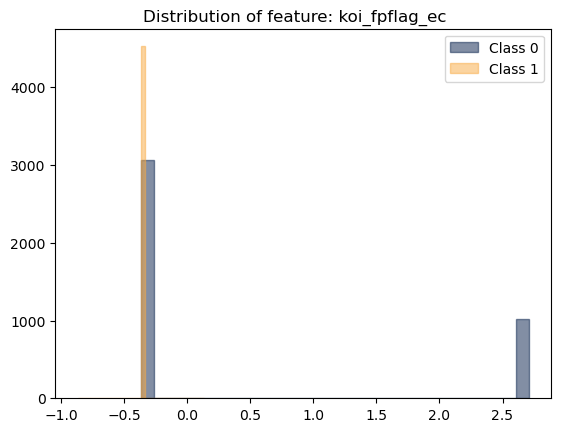

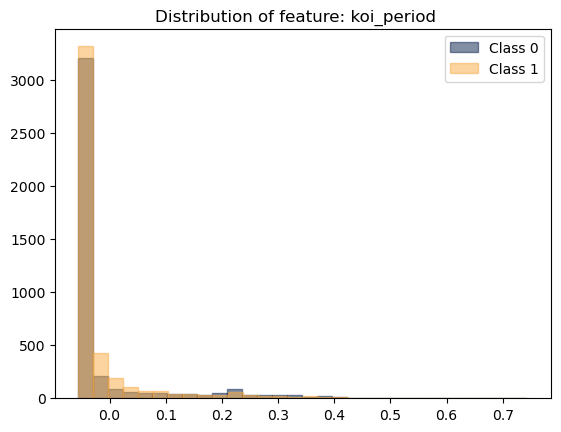

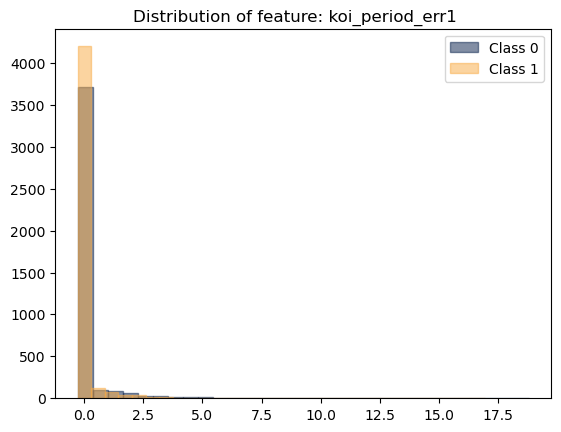

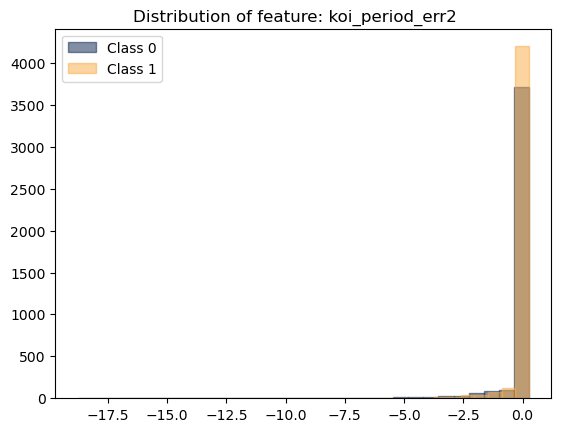

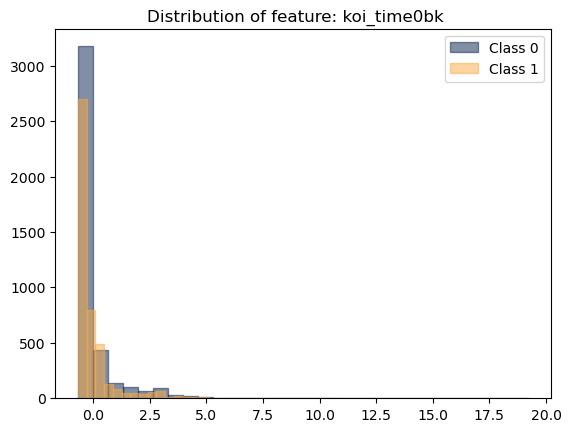

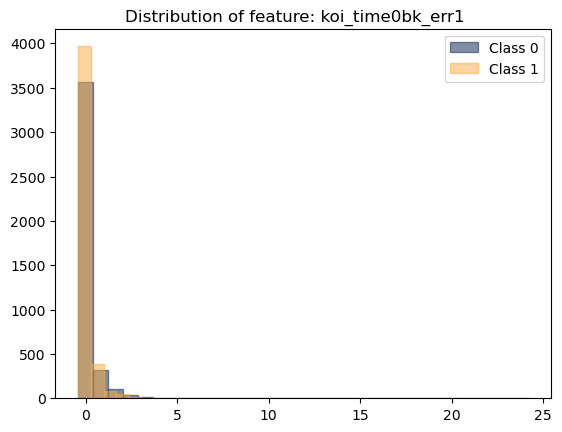

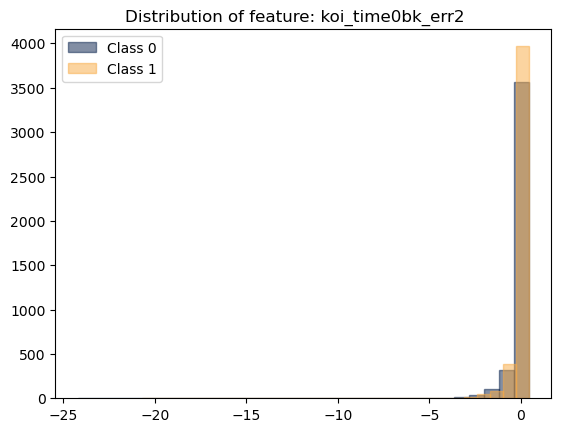

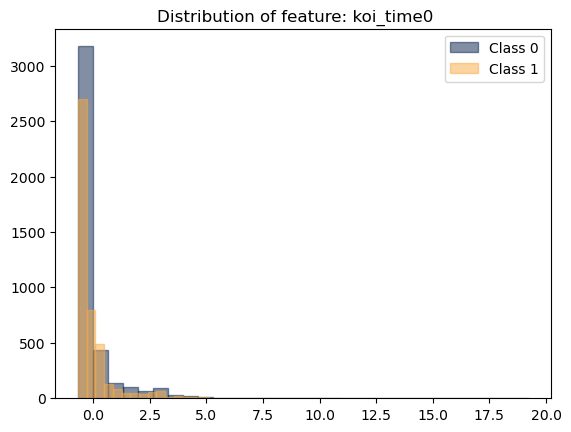

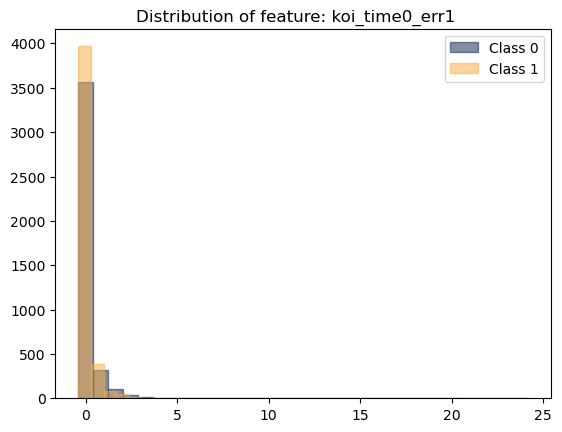

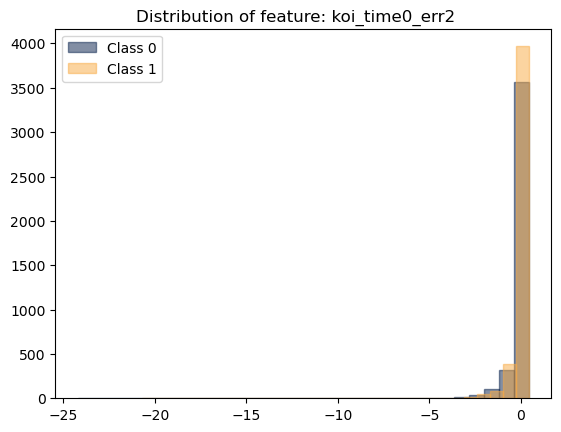

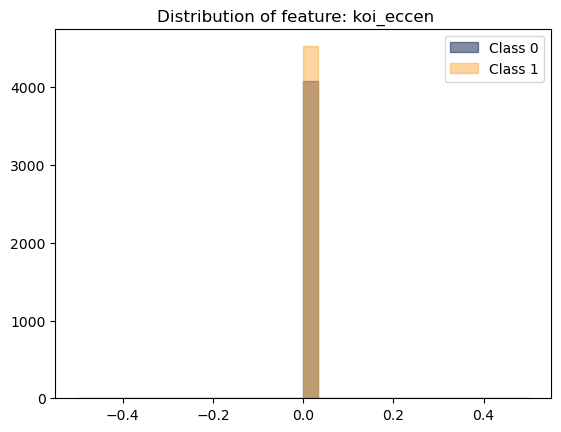

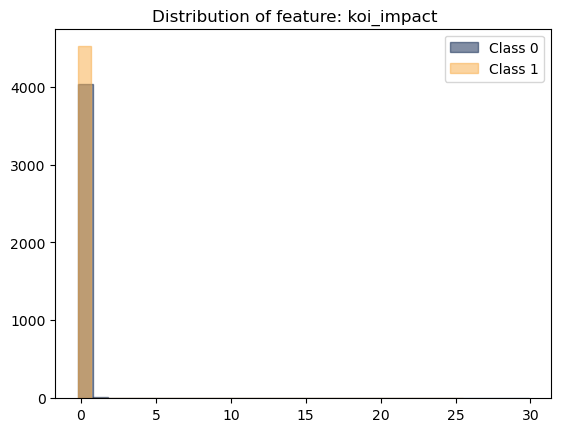

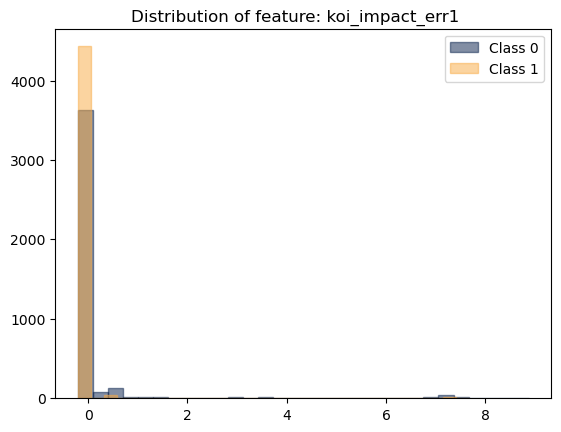

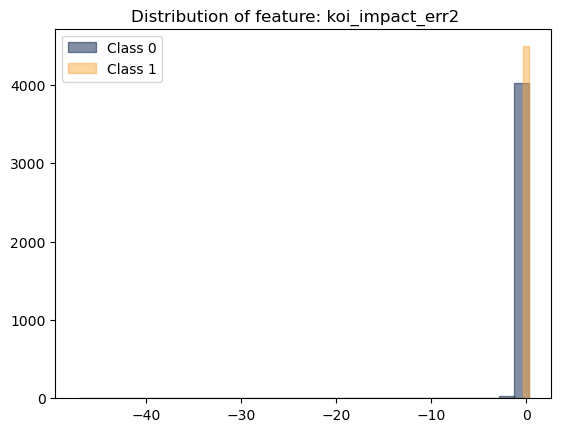

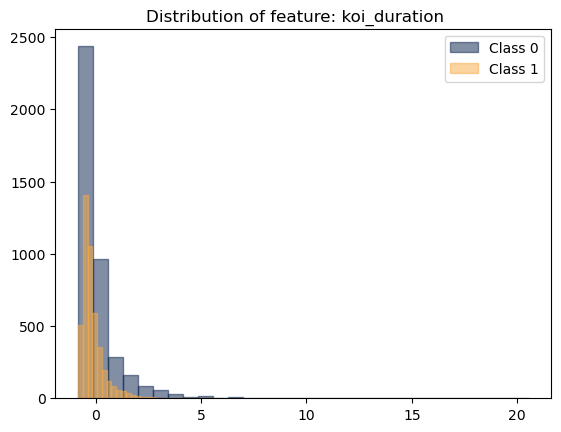

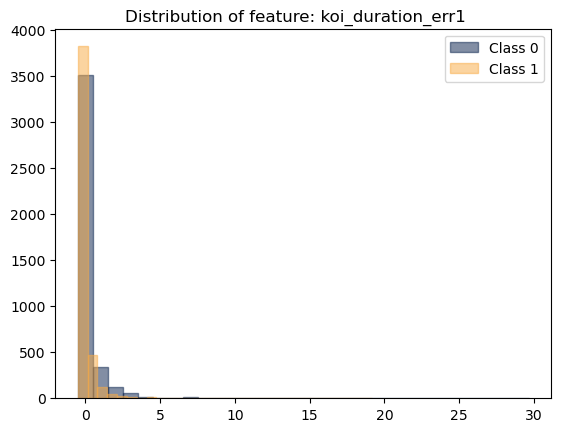

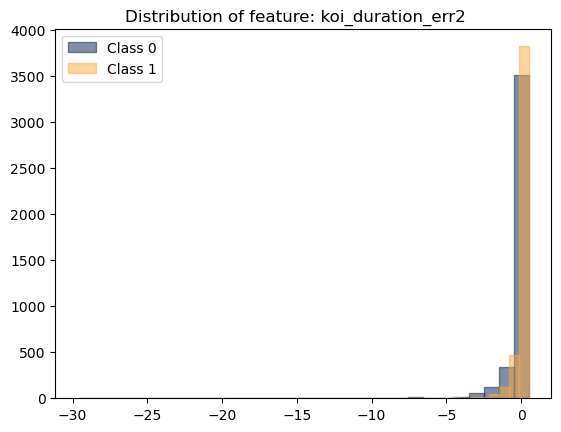

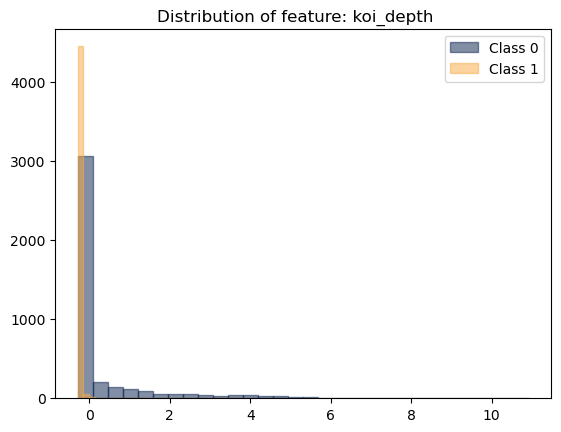

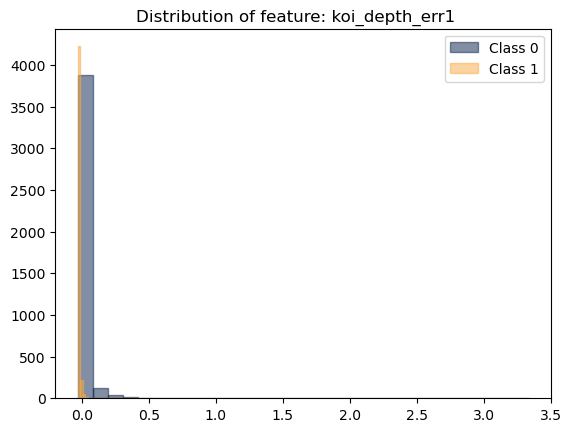

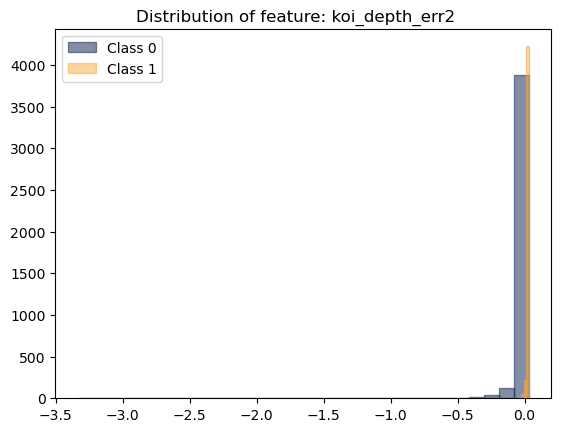

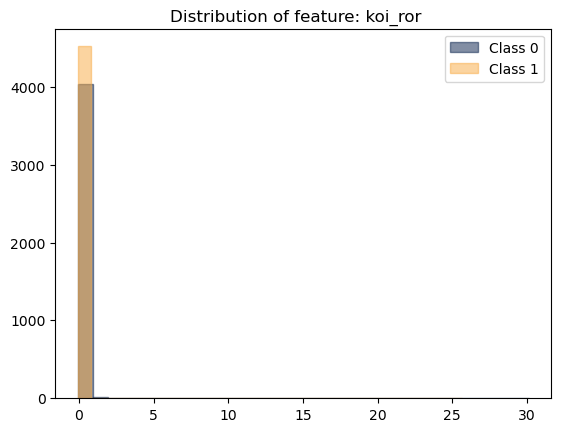

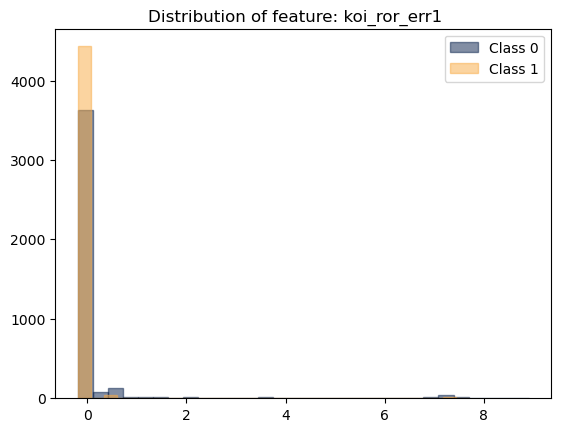

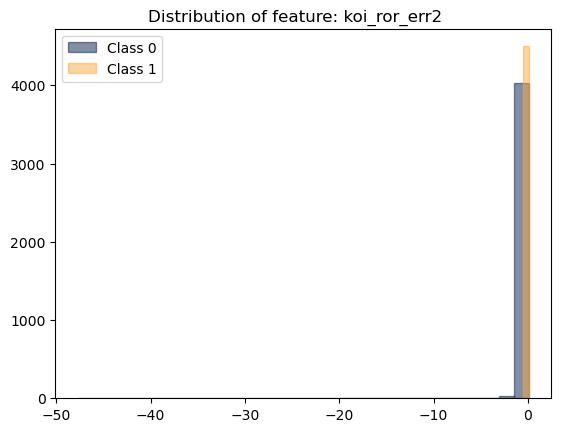

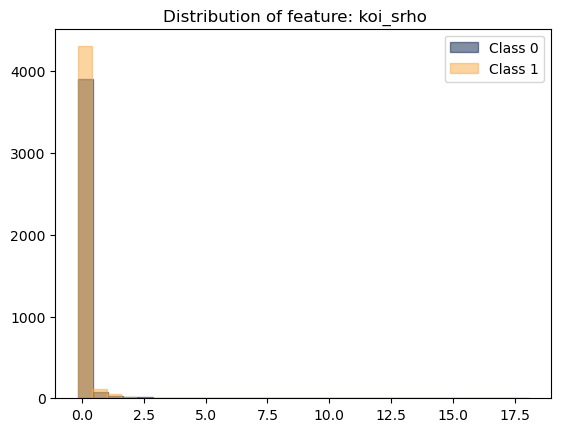

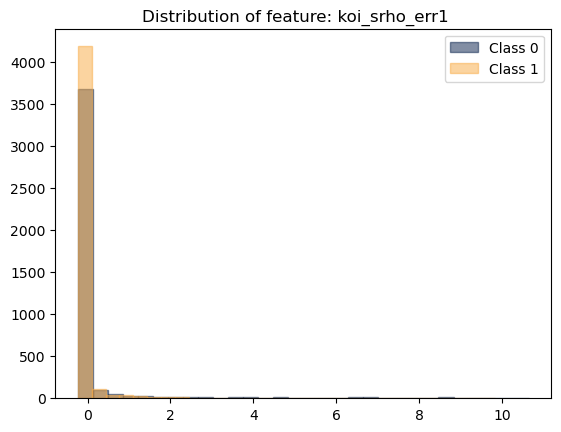

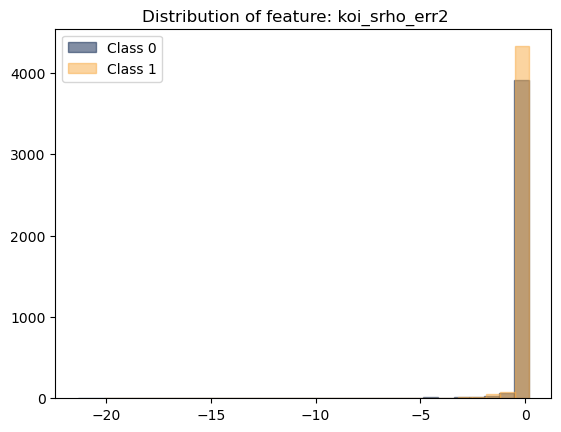

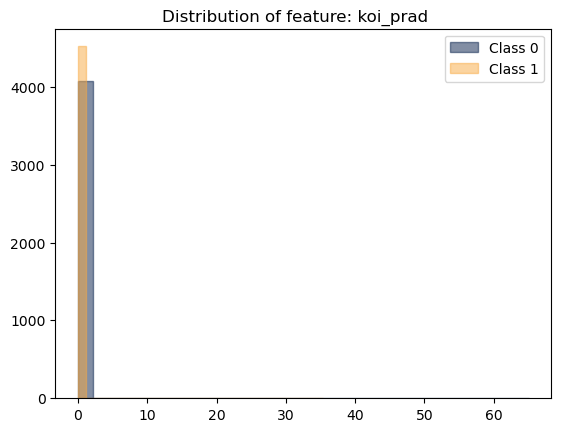

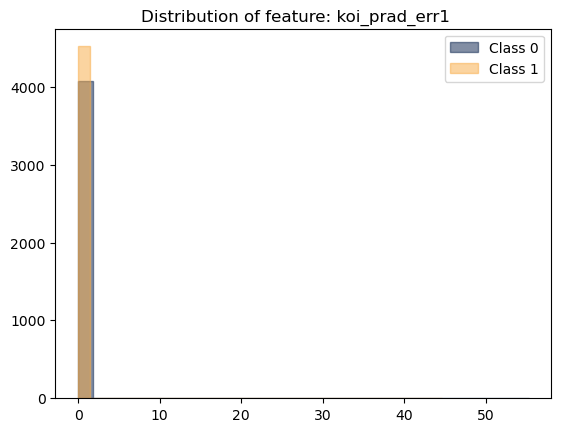

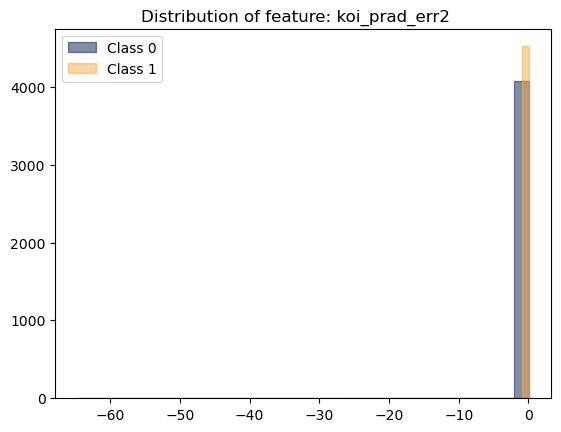

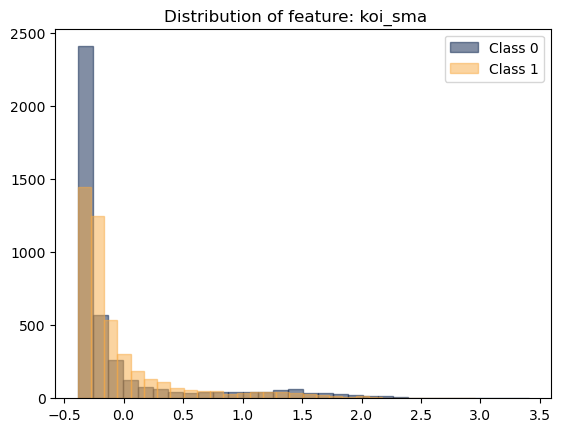

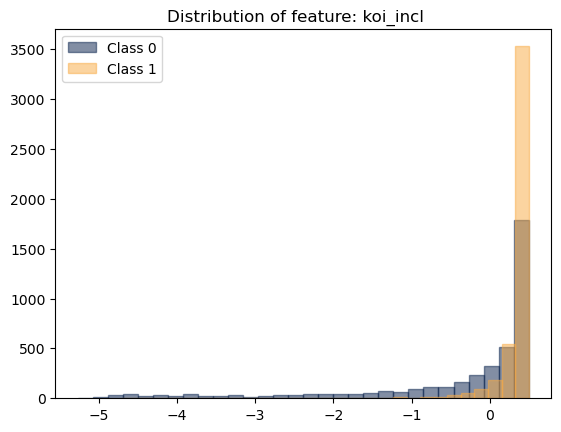

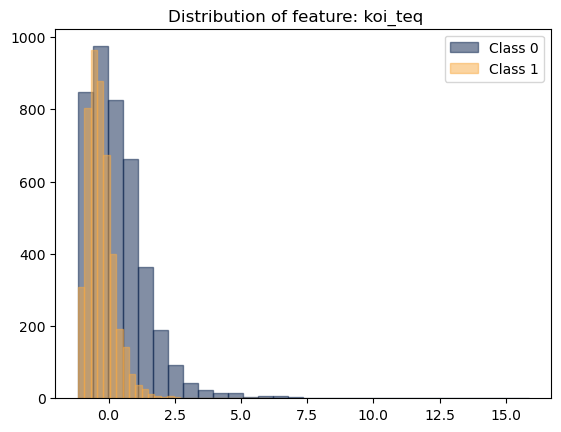

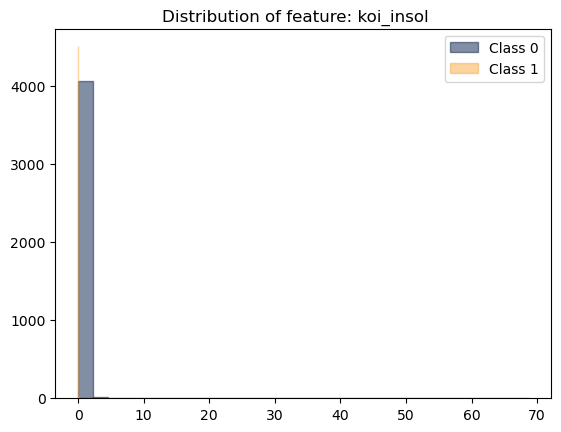

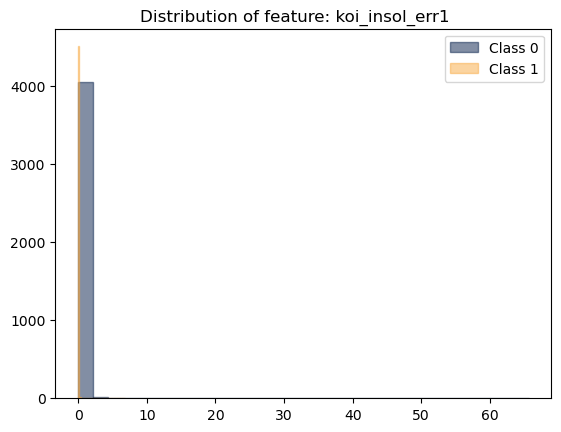

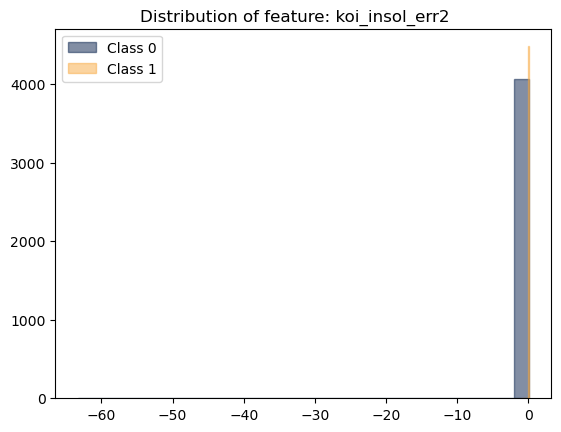

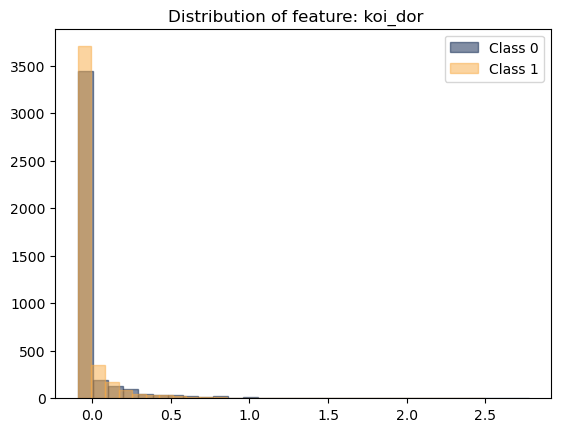

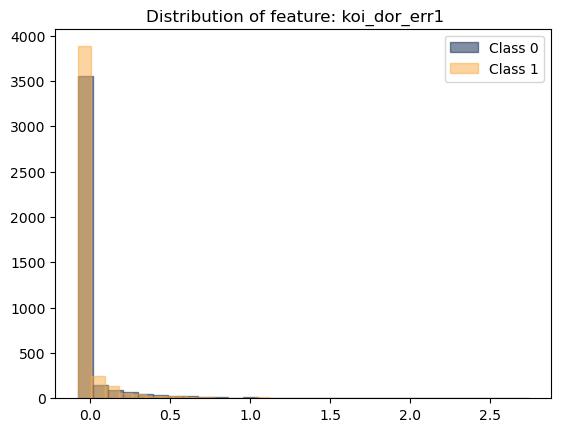

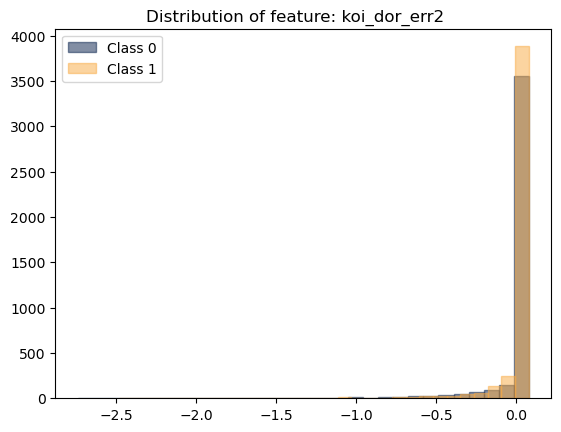

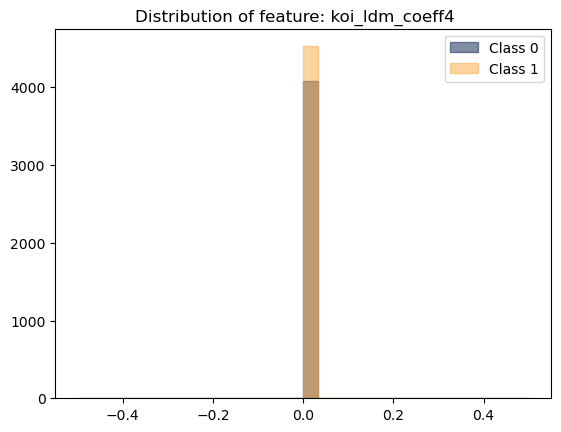

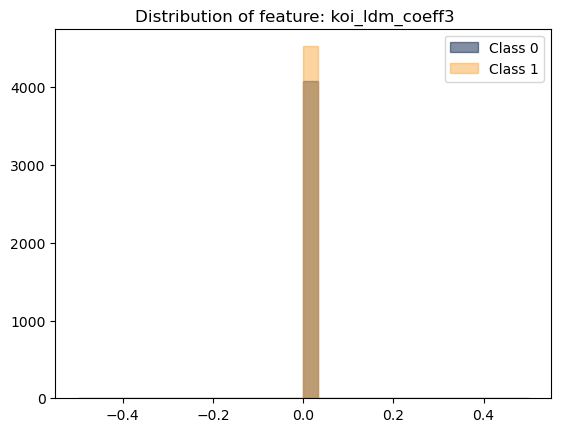

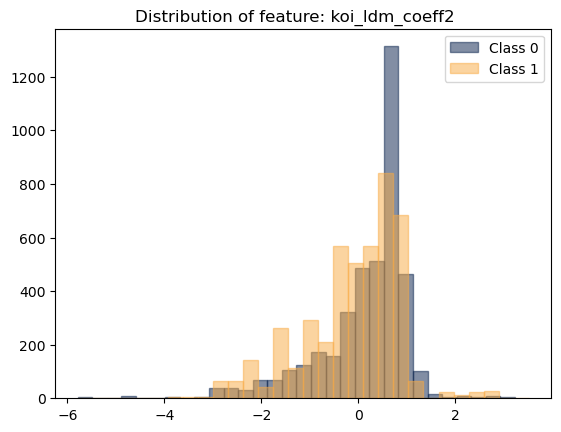

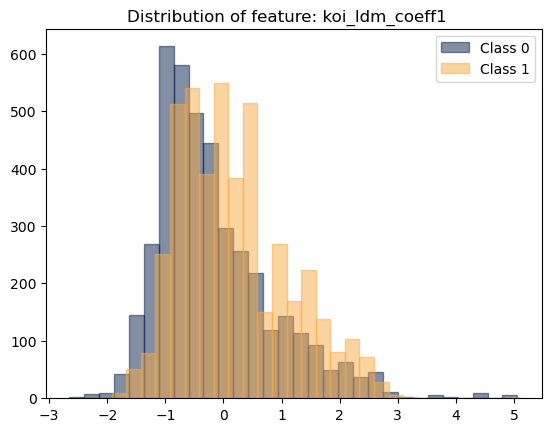

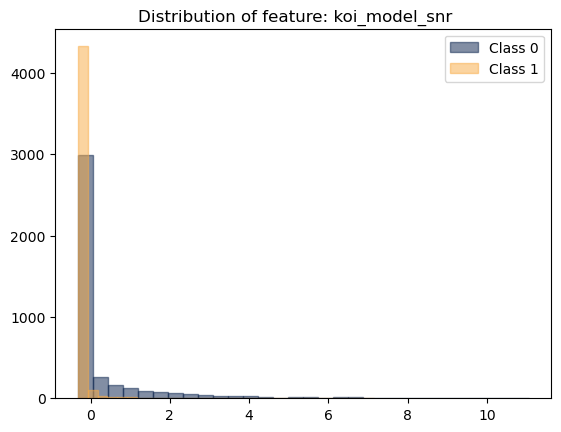

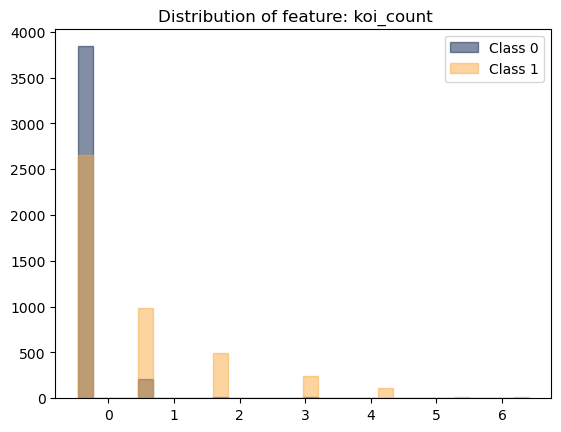

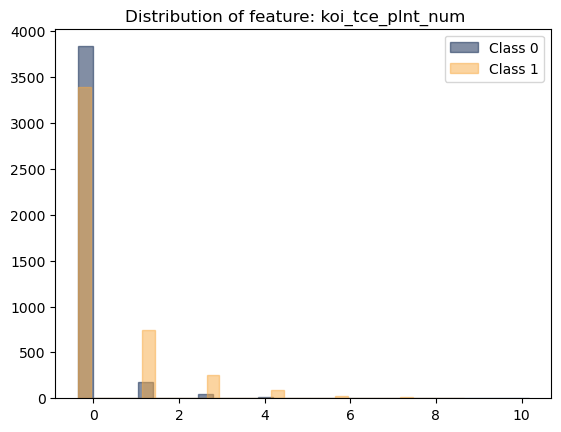

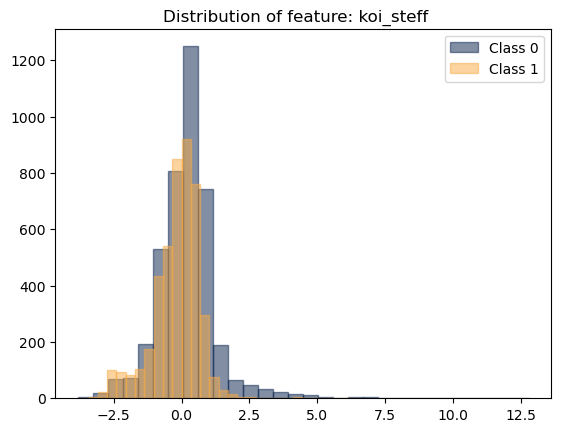

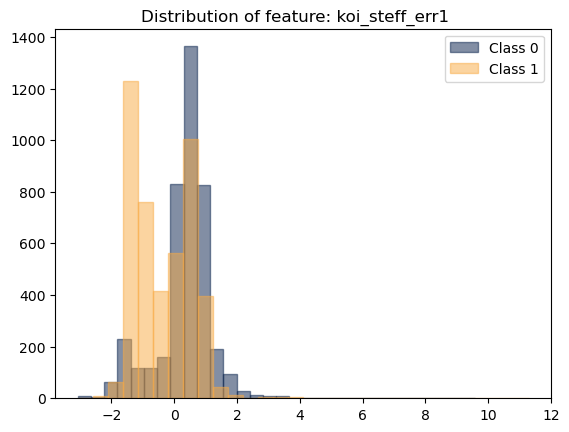

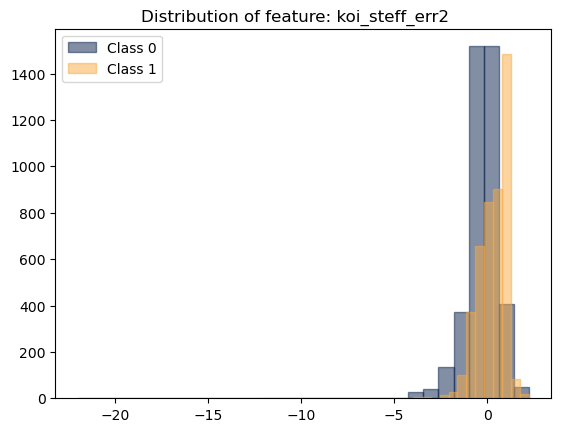

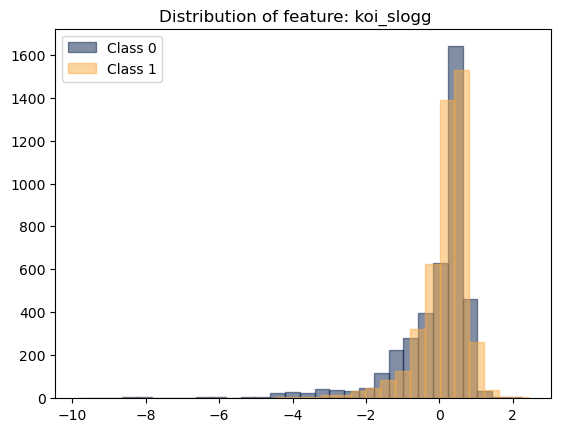

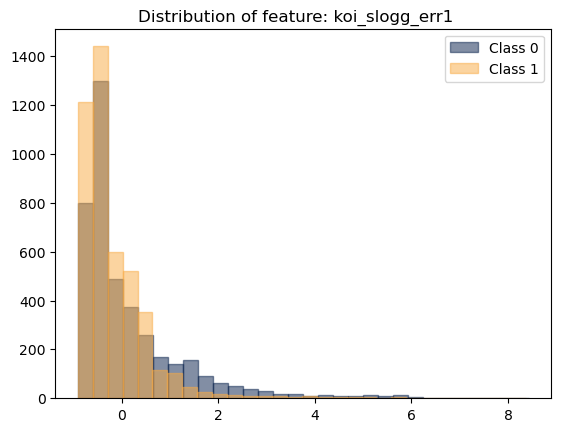

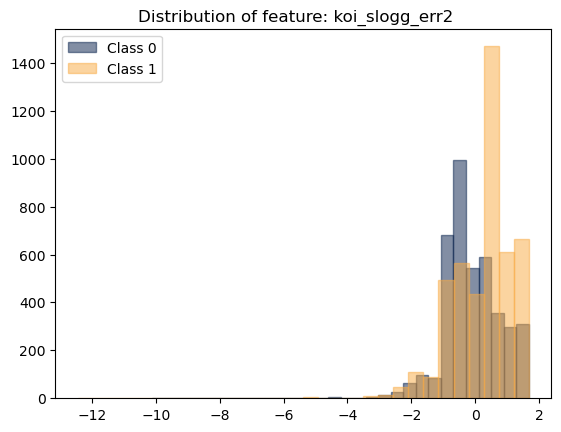

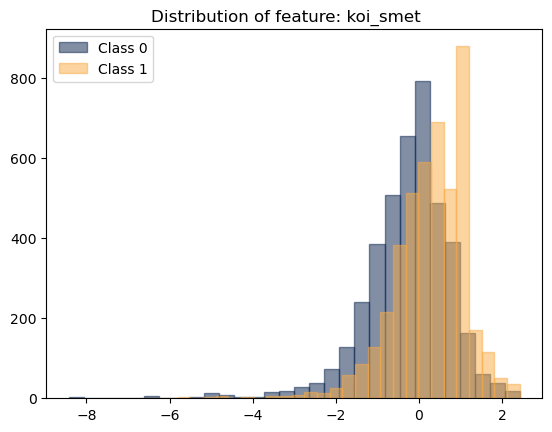

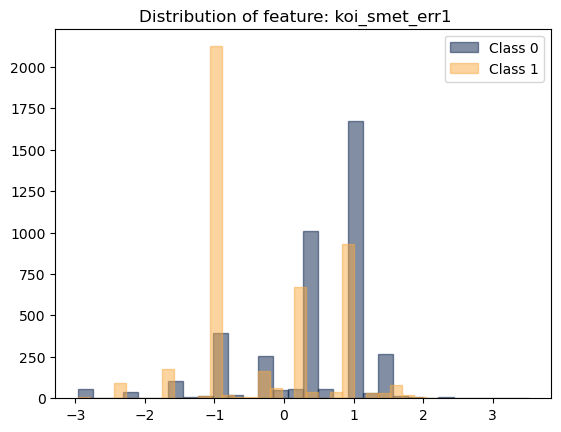

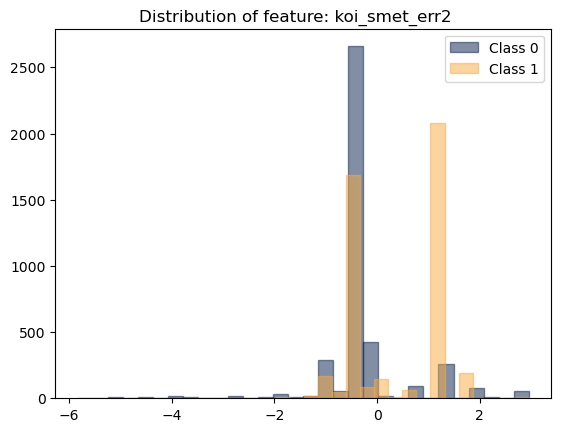

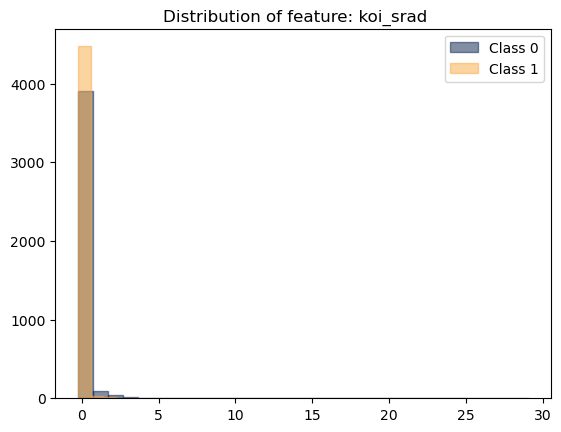

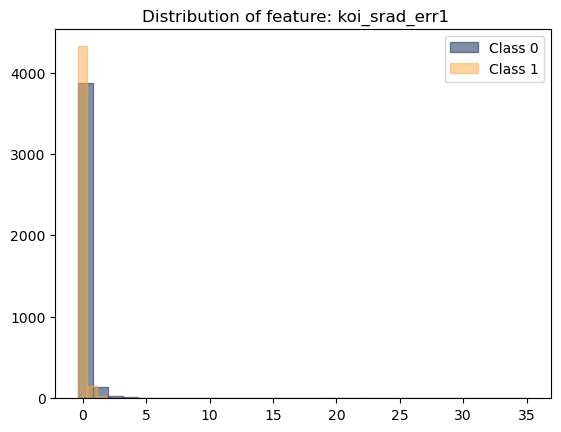

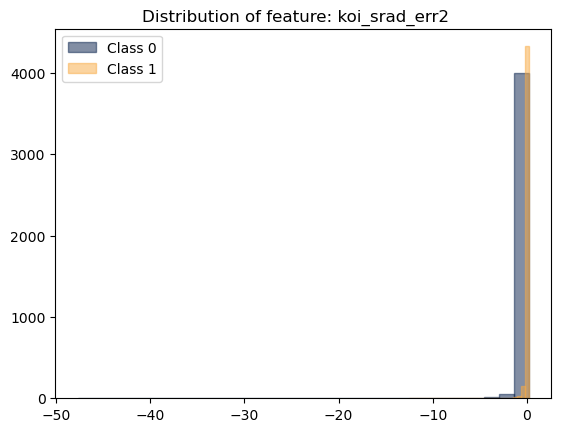

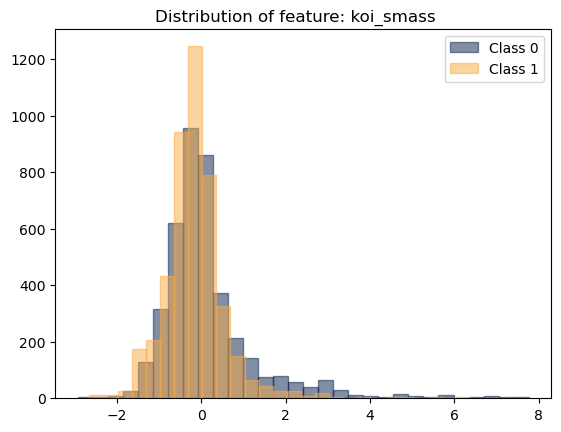

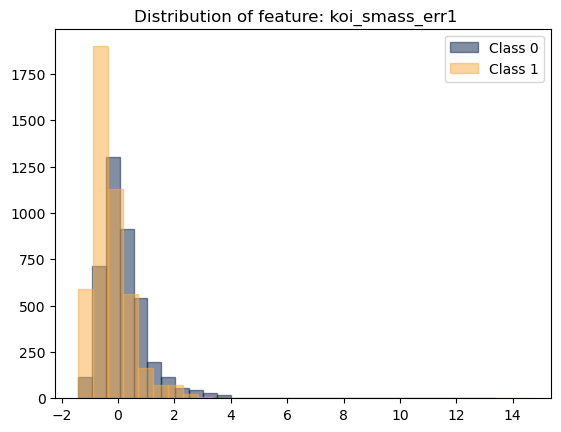

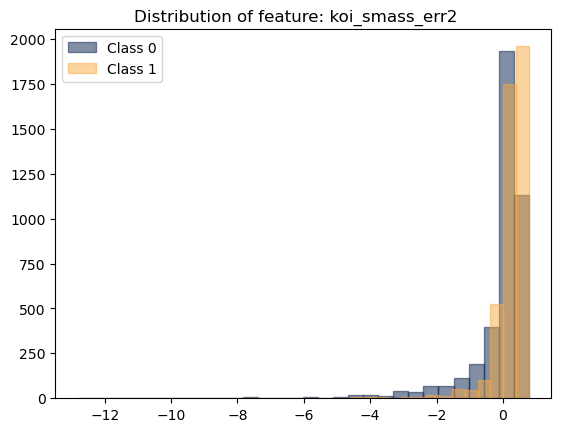

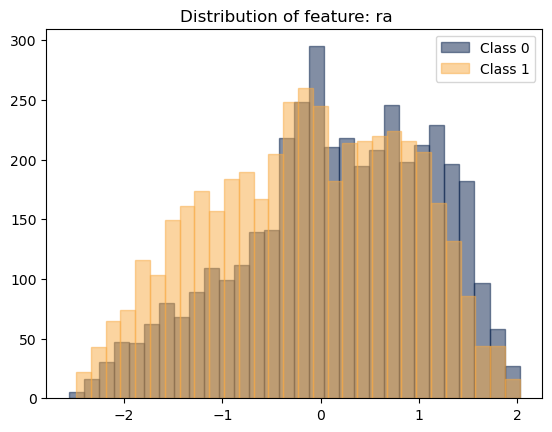

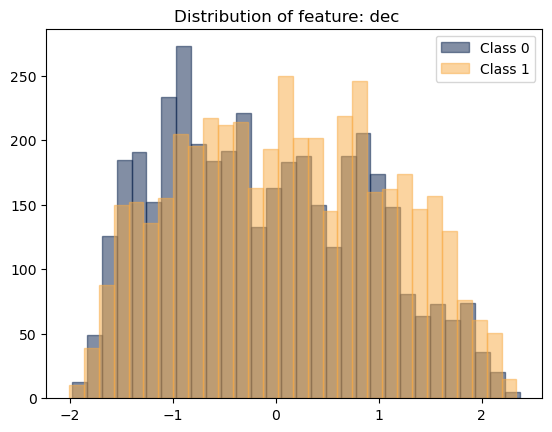

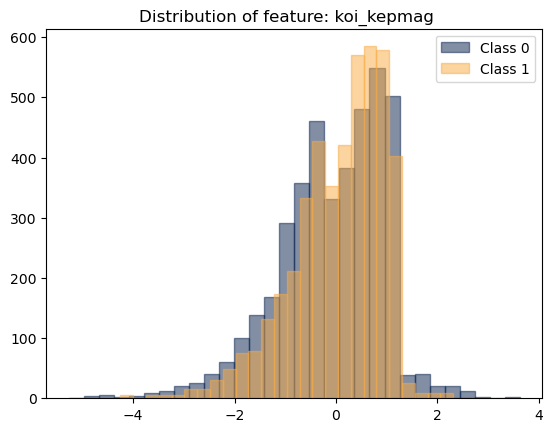

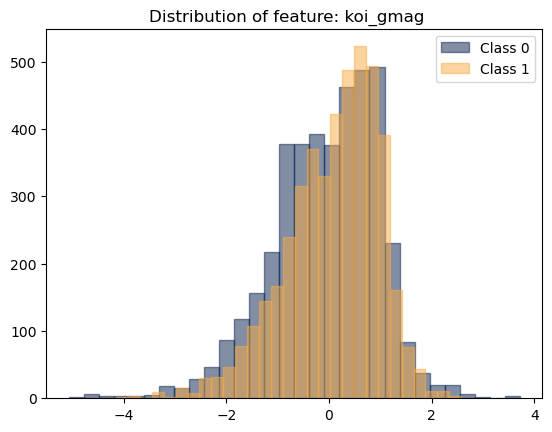

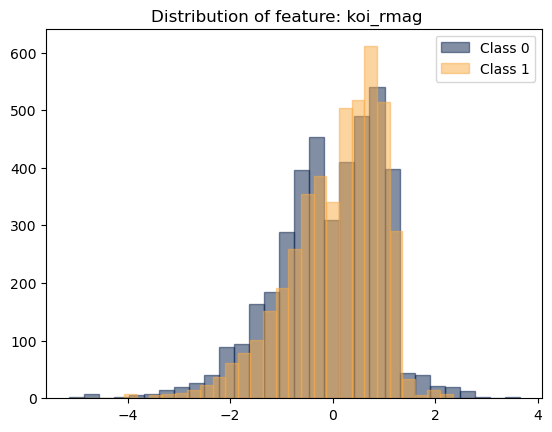

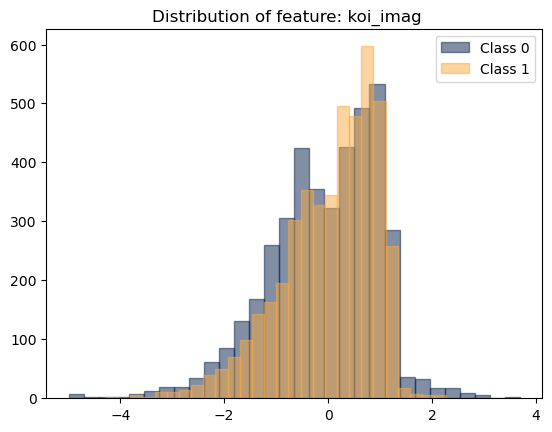

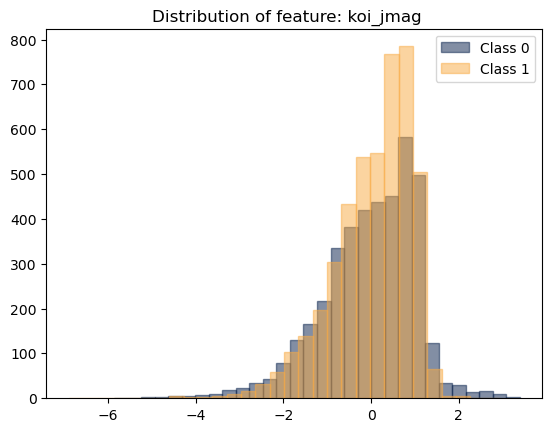

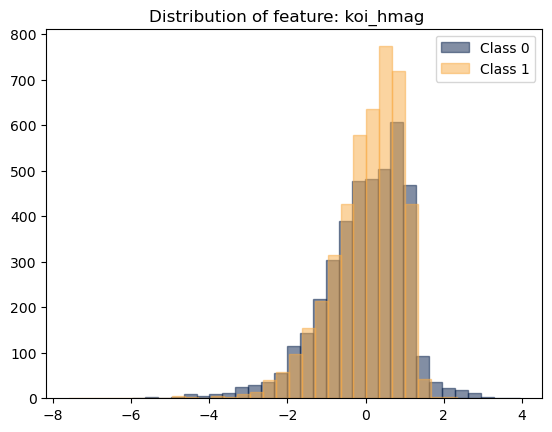

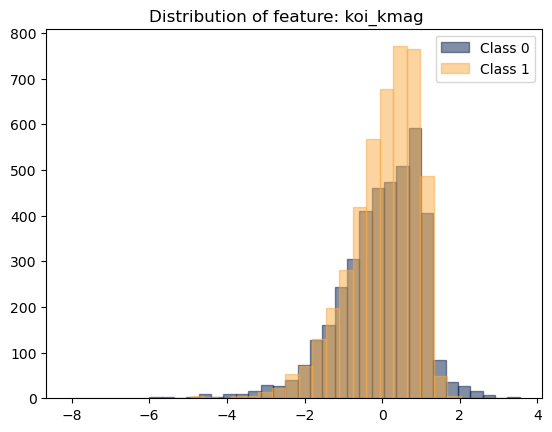

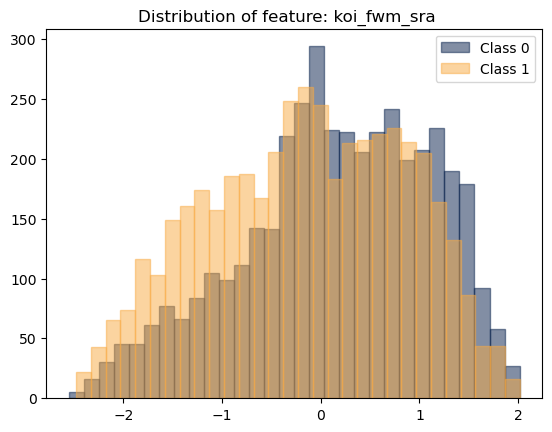

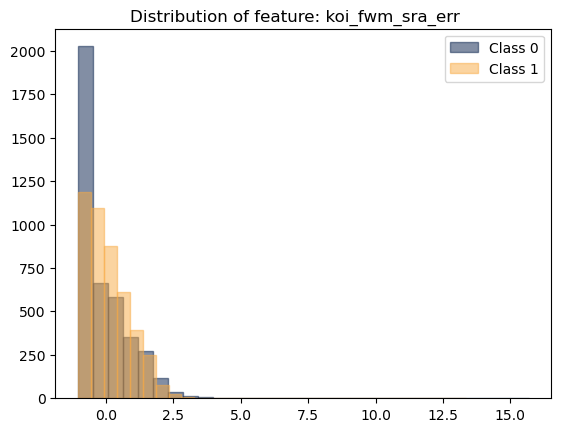

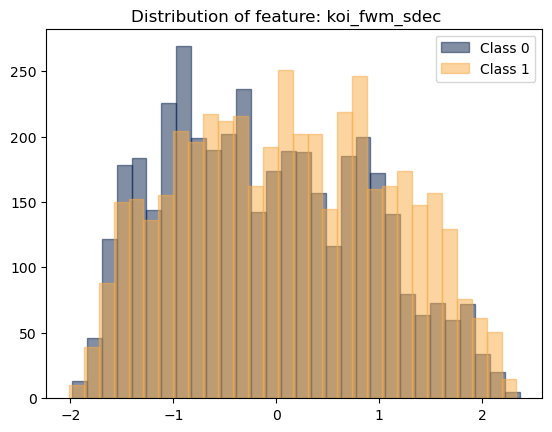

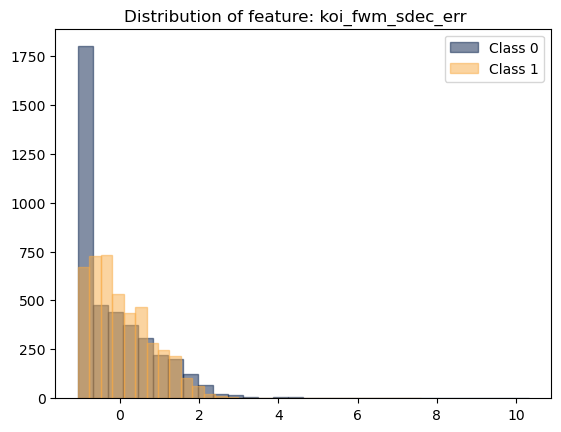

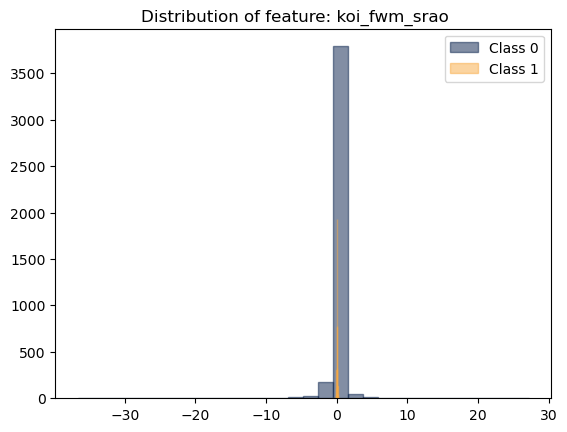

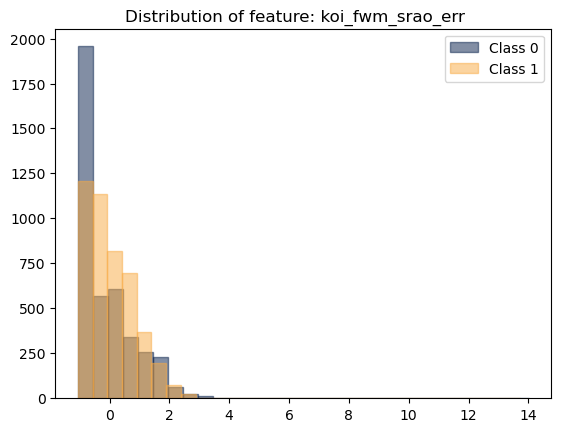

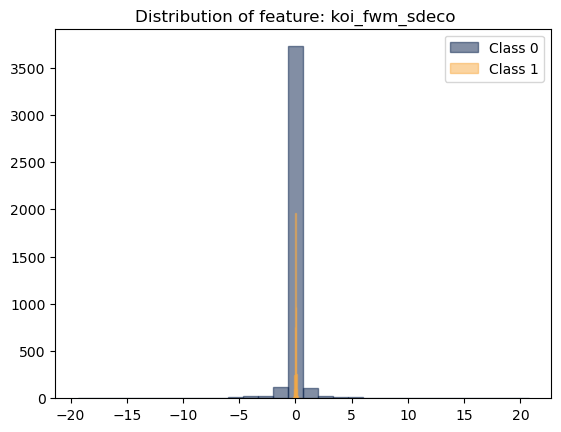

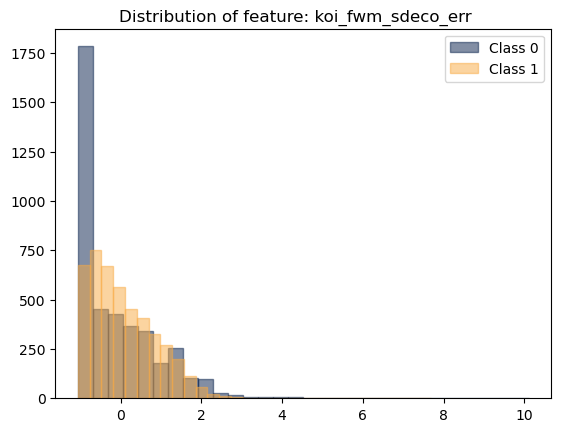

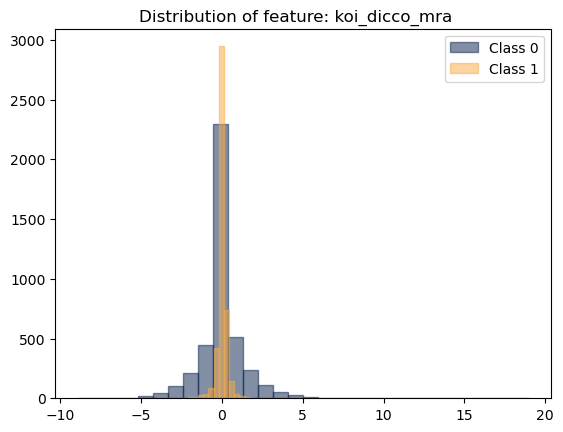

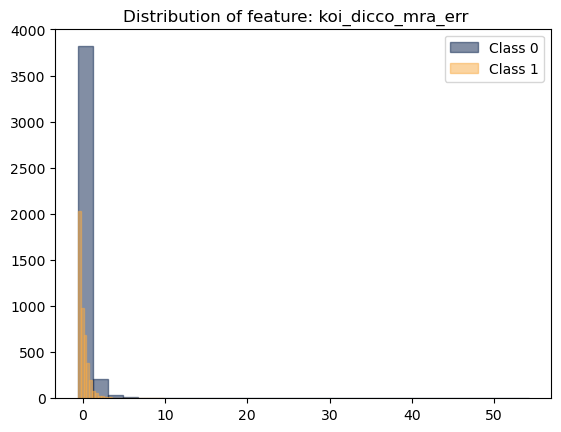

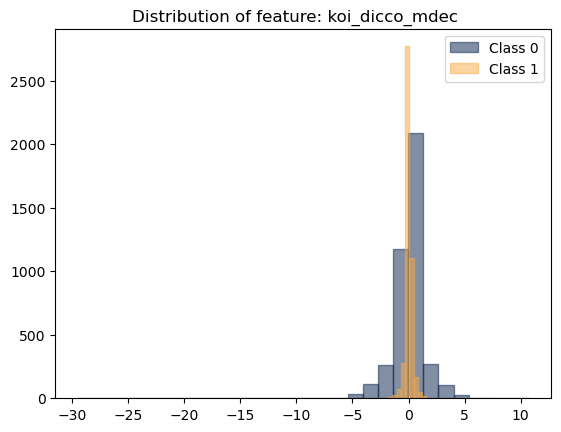

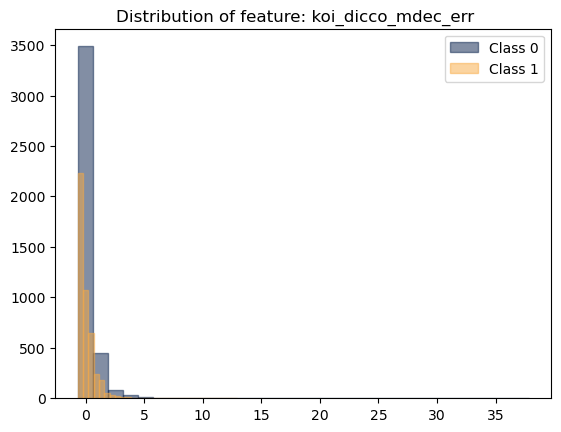

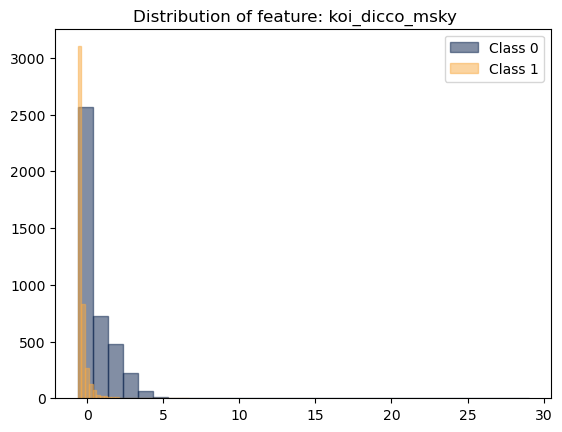

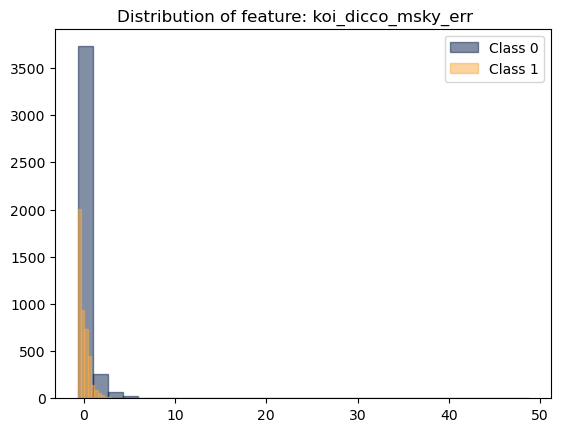

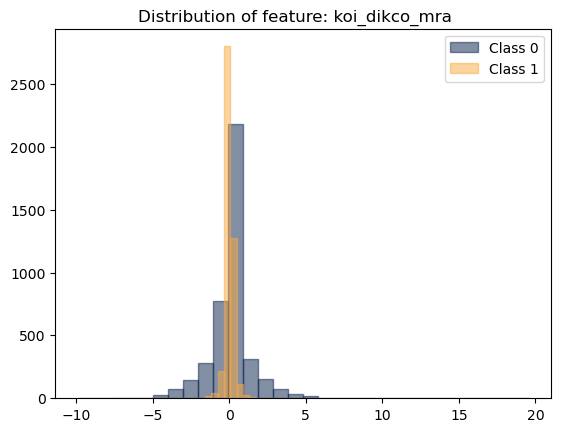

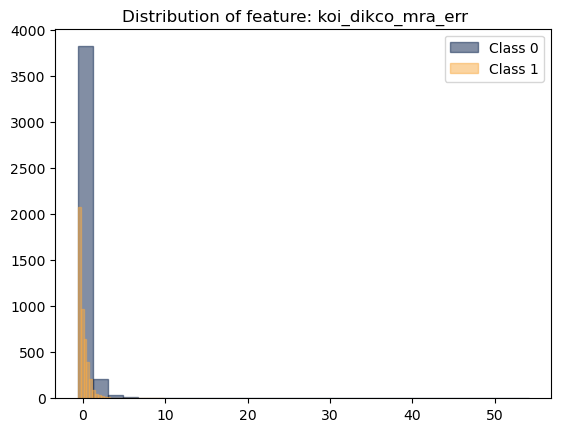

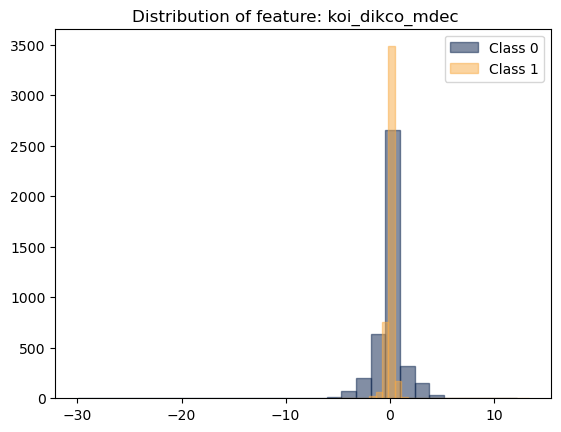

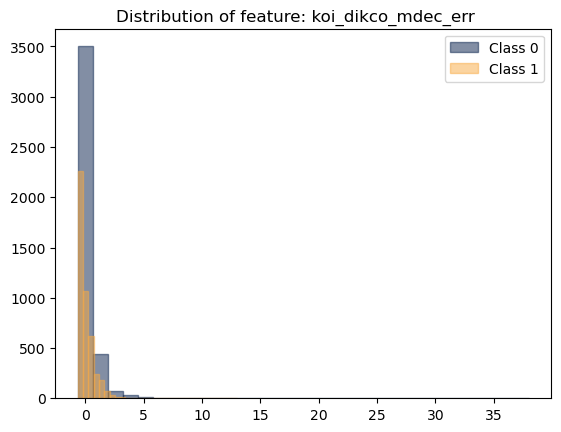

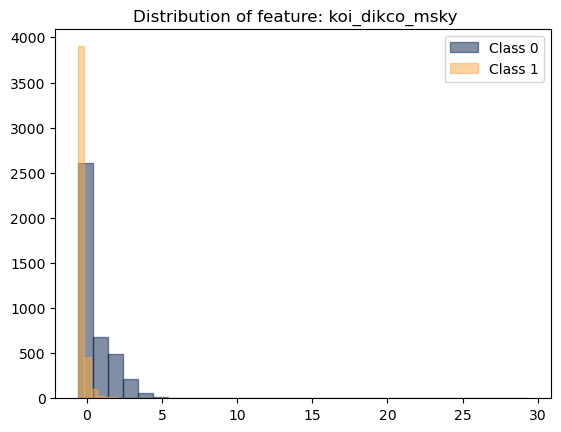

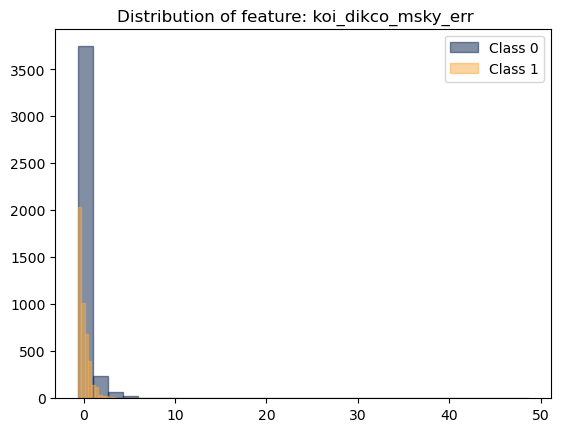

In [16]:
print('Plot After the scaling and KNNImputer')
plot_top_7_difference(X_train=X_train)
plot_hist_feature_distributions(X_train=X_train)
X_train_0, X_train_1 = compute_train_0_1(X_train=X_train, y_train=y_train)
plot_hist_feature_distributions(X_train=X_train_0)
plot_hist_feature_distributions(X_train=X_train_1)
plot_hist_feature_distributions_0_1(X_train_0=X_train_0, X_train_1=X_train_1)

# Feature Selection

Feature selection is a technique that associates a score with each feature and, based on a threshold T, thresholding is carried out so as to leave only the most important features. This technique is used to reduce overfitting and computational times.

It is done through the use of a Random Forest which provides us with the importance of the features.

In [17]:
N_JOBS = -1

In [18]:
feature_importances_ = compute_feature_importance(X_train=X_train, y_train=y_train, n_jobs=N_JOBS)
print_feature_importance(X_train=X_train, feature_importances_=feature_importances_)

1: koi_fpflag_nt-----------------> 0.08813396789570509
2: koi_fpflag_co-----------------> 0.0793990005911482
3: koi_fpflag_ss-----------------> 0.07556396711789795
4: koi_dikco_msky----------------> 0.04539637867117913
5: koi_fpflag_ec-----------------> 0.03930640067070766
6: koi_prad----------------------> 0.035490928667836485
7: koi_dicco_msky----------------> 0.033230015677704186
8: koi_ror-----------------------> 0.027686476273724177
9: koi_dor-----------------------> 0.024534630108887876
10:koi_prad_err1-----------------> 0.0238664929594008
11:koi_prad_err2-----------------> 0.021145792431844303
12:koi_smet_err2-----------------> 0.015270269903778989
13:koi_dikco_mdec_err------------> 0.014442529471512847
14:koi_depth---------------------> 0.014116902088823513
15:koi_dikco_msky_err------------> 0.011207443958309617
16:koi_fwm_sdeco_err-------------> 0.011077406429578452
17:koi_ror_err1------------------> 0.011074183572190243
18:koi_fwm_srao_err--------------> 0.010977422197635195


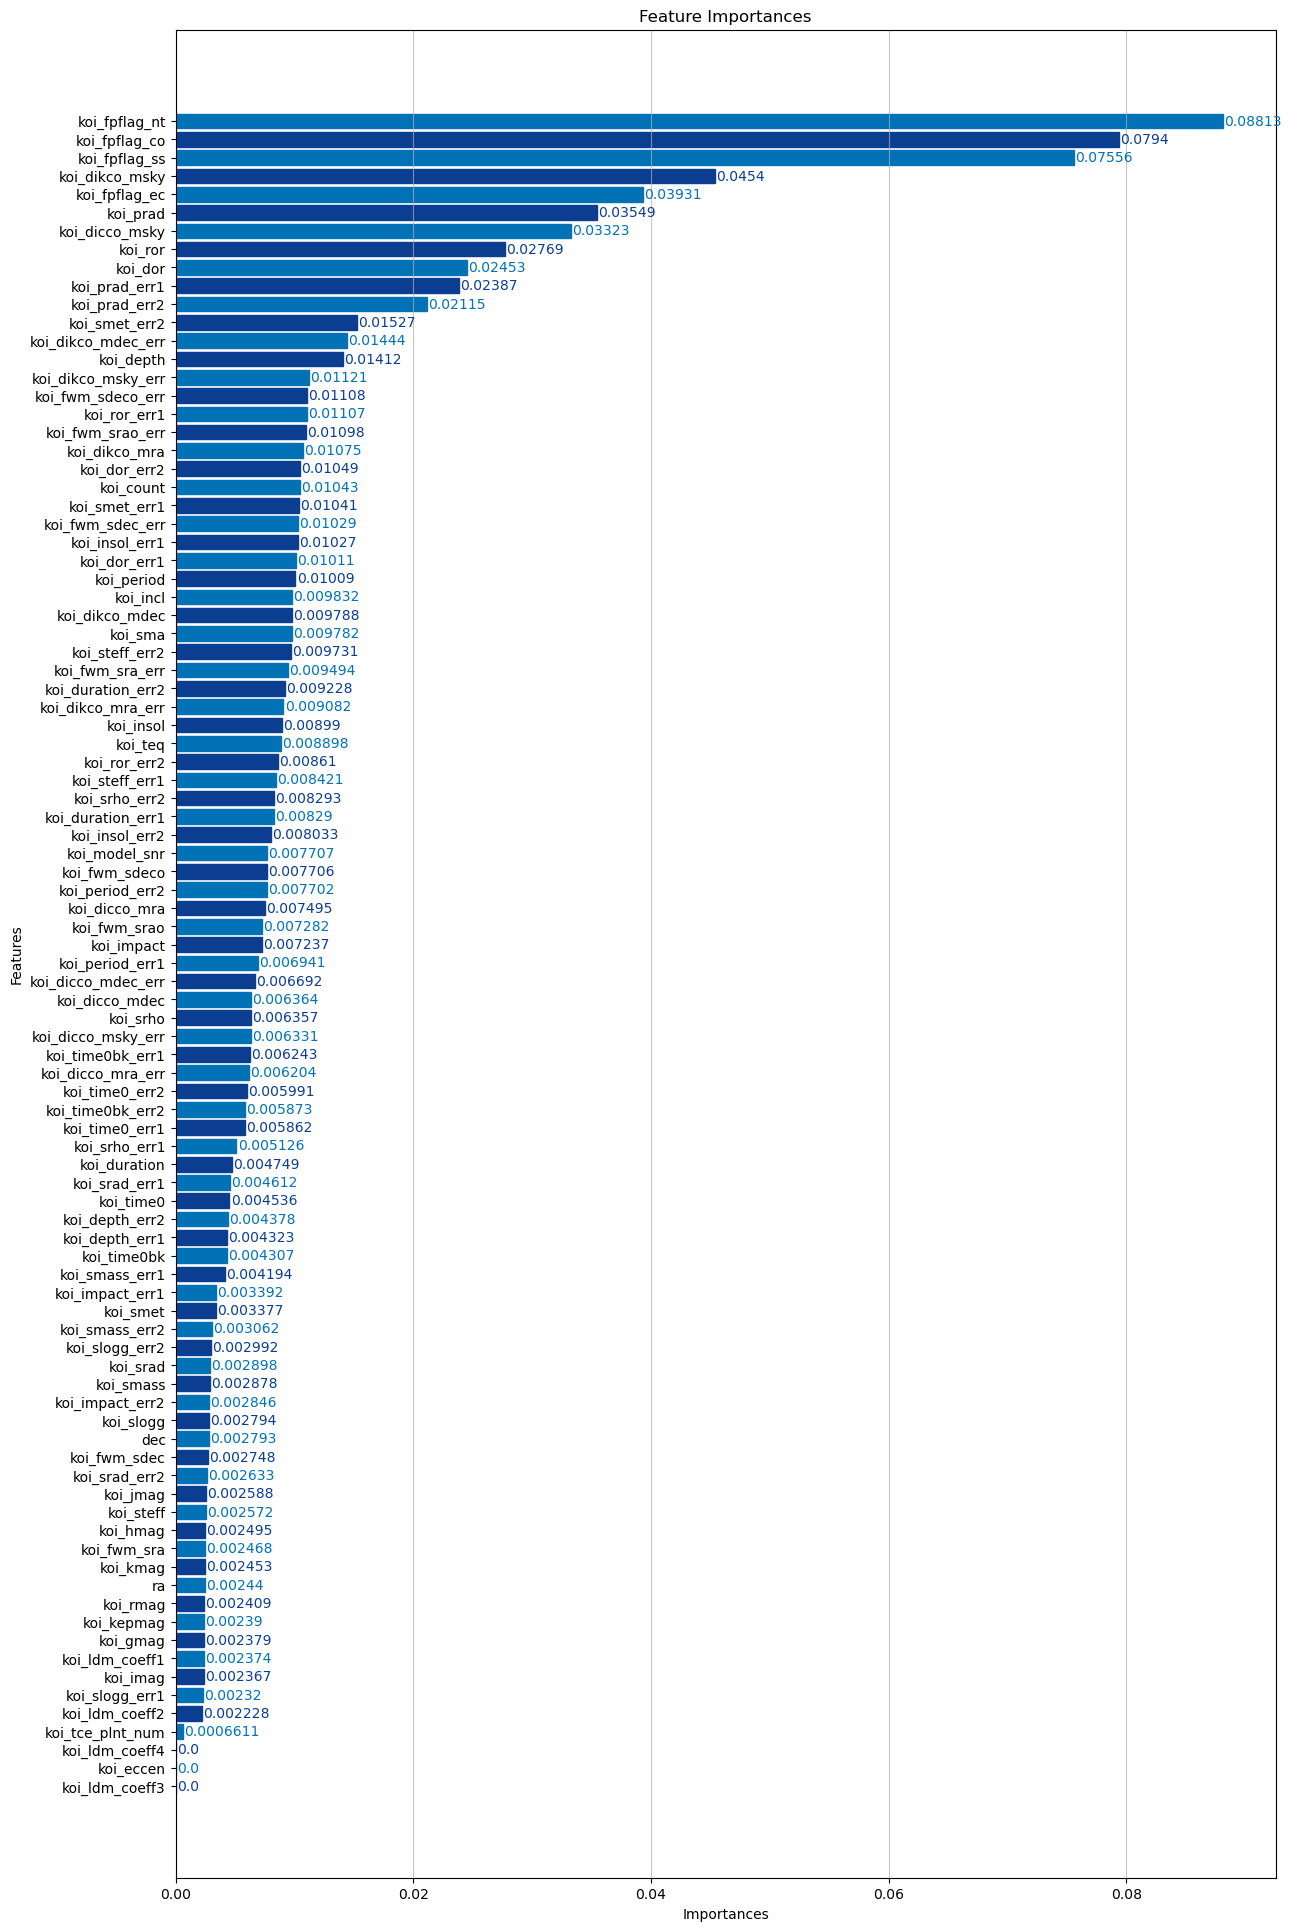

In [19]:
plot_feature_importances(X_train=X_train, feature_importances=feature_importances_)

In [20]:
PERCENTAGE = 0 # Drop features with importance = 0
X_train, columns_to_drop = feature_selection_rfc(X_train=X_train, feature_importances=feature_importances_,
                                                 percentage=PERCENTAGE)
print('Columns to drop:', columns_to_drop)
print('Shape of X_train data: ', X_train.shape)

Threshold computed:  0.0
Columns to drop: Index(['koi_eccen', 'koi_ldm_coeff4', 'koi_ldm_coeff3'], dtype='object')
Shape of X_train data:  (8608, 89)


# Dataset balancing

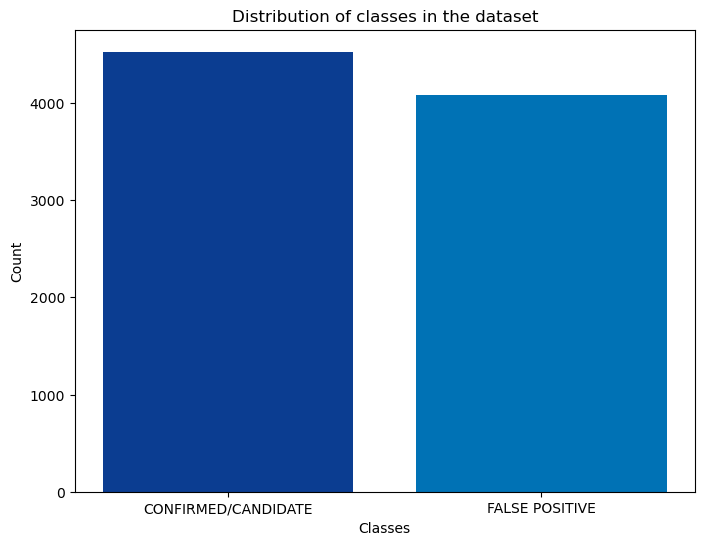

In [21]:
class_count_1, class_count_0 = plot_class_distribution(y_train=y_train)

In [22]:
print('Observations labeled 1:', class_count_1)
print('Observations labeled 0:', class_count_0)

Observations labeled 1: 4527
Observations labeled 0: 4081


In [23]:
# Save processed data
X_train.to_csv('../data/processed_data/X_kepler_followup_ss.csv')
y_train.to_csv('../data/processed_data/y_kepler_followup_ss.csv')

# Train Test Split

In [24]:
TESTSET_SIZE = 0.2
RANDOM_STATE = 42

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=TESTSET_SIZE, 
                                                    random_state=RANDOM_STATE, shuffle=True, stratify=None)

# Checking class distributions after the split

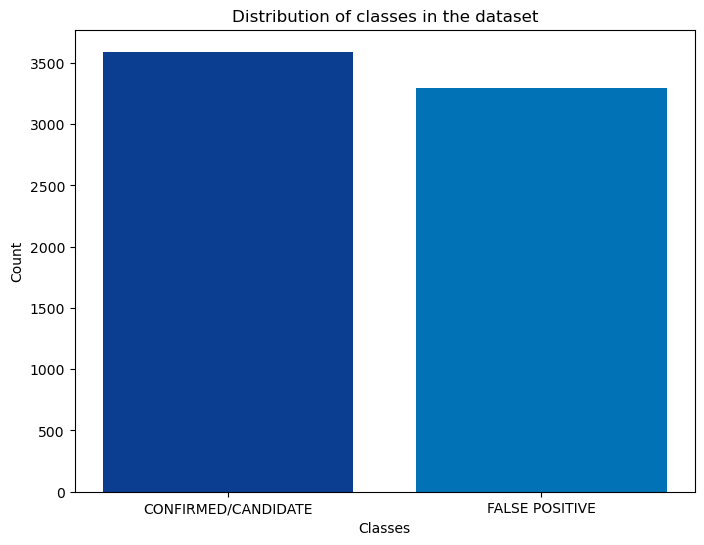

In [25]:
_, _ = plot_class_distribution(y_train=y_train)

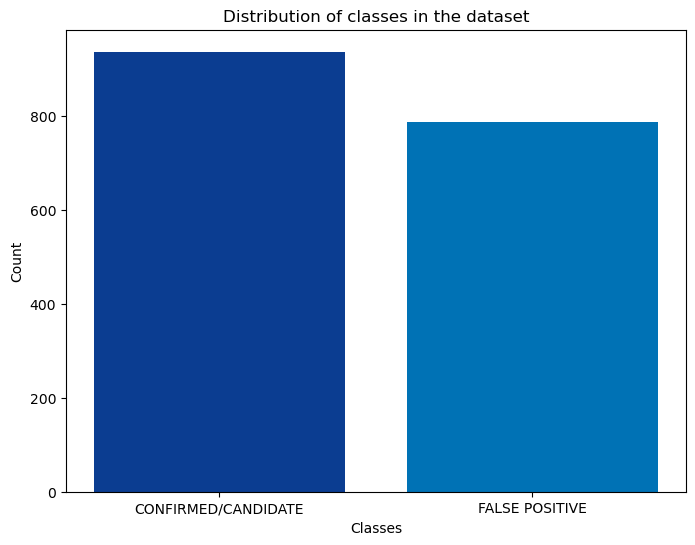

In [26]:
_, _ = plot_class_distribution(y_train=y_test)

In [27]:
print('Shape of X_train data: ', X_train.shape)
print('Shape of y_train data: ', y_train.shape)
print('Shape of X_test data: ', X_test.shape)
print('Shape of y_test data: ', y_test.shape)

Shape of X_train data:  (6886, 89)
Shape of y_train data:  (6886,)
Shape of X_test data:  (1722, 89)
Shape of y_test data:  (1722,)


# Grid Searh

A common method that determines optimal parameters by evaluating metrics
of the model

In [28]:
best_params, best_score, best_estimator = grid_search_param_optimization(X_train=X_train, 
                                                                         y_train=y_train, n_jobs=N_JOBS)
print('Best params:', best_params)
print('Best score:', best_score)
print('Best estimator:', best_estimator)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.4s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.5s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=2, max_features=2, min_samples_split=3, n_estimators=100; total time=   0.6s
[CV] END max_depth=2, max_features=2, min_samples_split=2, n_estimators=

In [29]:
# Best params: {'max_depth': 11, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 300}
# Best score: 0.996659931510098
# Best estimator: RandomForestClassifier(max_depth=11, max_features=None, min_samples_split=5,
#                        n_estimators=300)

# Best params: {'max_depth': None, 'max_features': 5, 'min_samples_split': 7, 'n_estimators': 300}
# Best score: 0.9822833761790477
# Best estimator: RandomForestClassifier(max_features=5, min_samples_split=7, n_estimators=300,
#                        n_jobs=-1)

# best_params = {}
# best_params['n_estimators'] = 300
# best_params['max_features'] = None
# best_params['max_depth'] = 11
# best_params['min_samples_split'] = 5

# Random Forest Classifier

A random forest classifier.

A random forest is a metaestimator that fits a set of decision tree classifiers on various subsamples of the dataset and uses averaging to improve predictive accuracy and control overfitting.

In [30]:
# Extracting best hyperparameters
N_ESTIMATORS = best_params['n_estimators'] # The number of trees in the forest
MAX_FEATURE = best_params['max_features'] # The number of features to consider when looking for the best split
MAX_DEPTH = best_params['max_depth'] # The maximum depth of the tree
MIN_SAMPLES_SPLIT = best_params['min_samples_split'] # Minimum number of samples required to split a node into terno
CRITERION = 'entropy' # The function to measure the quality of a split

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=N_ESTIMATORS, criterion=CRITERION, 
                               max_depth=MAX_DEPTH, max_features=MAX_FEATURE,
                               min_samples_split=MIN_SAMPLES_SPLIT, random_state=RANDOM_STATE, n_jobs=N_JOBS)

model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features=5, min_samples_split=3,
                       n_estimators=300, n_jobs=-1, random_state=42)

$$
\text{Accuracy}: \frac{\text{true positives + true negatives}}{\text{true positives + true negatives + false positives + false negatives}}
$$ 


$$
\text{F-score}: 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

$$
\text{Precision}: \frac{\text{true positives}}{\text{true positives + false positives}}
$$


$$
\text{Recall}: \frac{\text{true positives}}{\text{true positives + false negatives}}
$$

Accuracy: 0.978513356562137
F1-score: 0.9800968262506725
Precision: 0.9869989165763814
Recall: 0.9732905982905983
cm:  [[774  12]
 [ 25 911]]


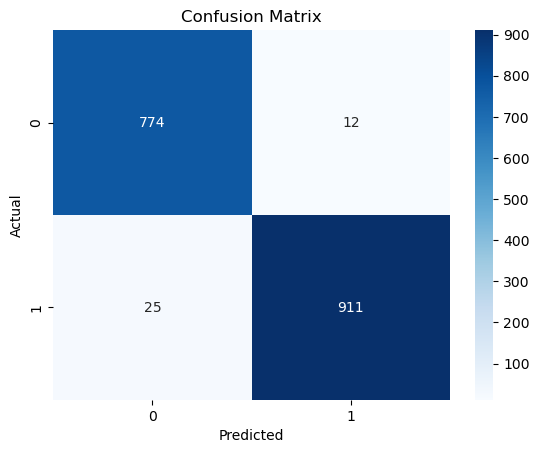

"\nN_ESTIMATORS = 300\nMAX_FEATURE = 5\nMAX_DEPTH = None\nMIN_SAMPLES_SPLIT = 7\nCRITERION = 'entropy'\nAccuracy: 97,96%\nF1-score: 98,11%\nPrecision: 98,91%\nRecall: 97,32%\ncm: [[776, 10][25, 911]]\n"

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

predictions = model.predict(X_test)

# Determine performance metrics
cm = confusion_matrix(y_test, predictions)
print('Accuracy:', accuracy_score(y_test, predictions))
print('F1-score:', f1_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))
print("cm: ", cm)

# Visualizza la matrice di confusione
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

"""
N_ESTIMATORS = 500
MAX_FEATURE = None
MAX_DEPTH = None
MIN_SAMPLES_SPLIT = 5
CRITERION = 'entropy'
Accuracy: 99,76%
F1-score: 99,78%
Precision: 99,78%
Recall: 99,78%
cm: [[784, 2][2, 934]]
"""

"""
N_ESTIMATORS = 300
MAX_FEATURE = 5
MAX_DEPTH = None
MIN_SAMPLES_SPLIT = 7
CRITERION = 'entropy'
Accuracy: 97,96%
F1-score: 98,11%
Precision: 98,91%
Recall: 97,32%
cm: [[776, 10][25, 911]]
"""

In [32]:
print_feature_importance(X_train=X_train, feature_importances_=model.feature_importances_)

1: koi_fpflag_co-----------------> 0.08325864076613392
2: koi_fpflag_nt-----------------> 0.07326420023264416
3: koi_fpflag_ss-----------------> 0.05948784871112499
4: koi_dikco_msky----------------> 0.04029466991900576
5: koi_dicco_msky----------------> 0.032796648286577246
6: koi_prad----------------------> 0.03055862662395433
7: koi_fpflag_ec-----------------> 0.02995790664623344
8: koi_ror-----------------------> 0.027191409003694055
9: koi_dor-----------------------> 0.025752685946074404
10:koi_prad_err2-----------------> 0.023199293508545337
11:koi_prad_err1-----------------> 0.021342083688791855
12:koi_smet_err2-----------------> 0.01540780075869977
13:koi_fwm_srao_err--------------> 0.014525315628290368
14:koi_steff_err1----------------> 0.013428752573944278
15:koi_ror_err1------------------> 0.012637276555015372
16:koi_dikco_msky_err------------> 0.012260658791229421
17:koi_dikco_mra-----------------> 0.012259851810122941
18:koi_dikco_mra_err-------------> 0.011930135804528895

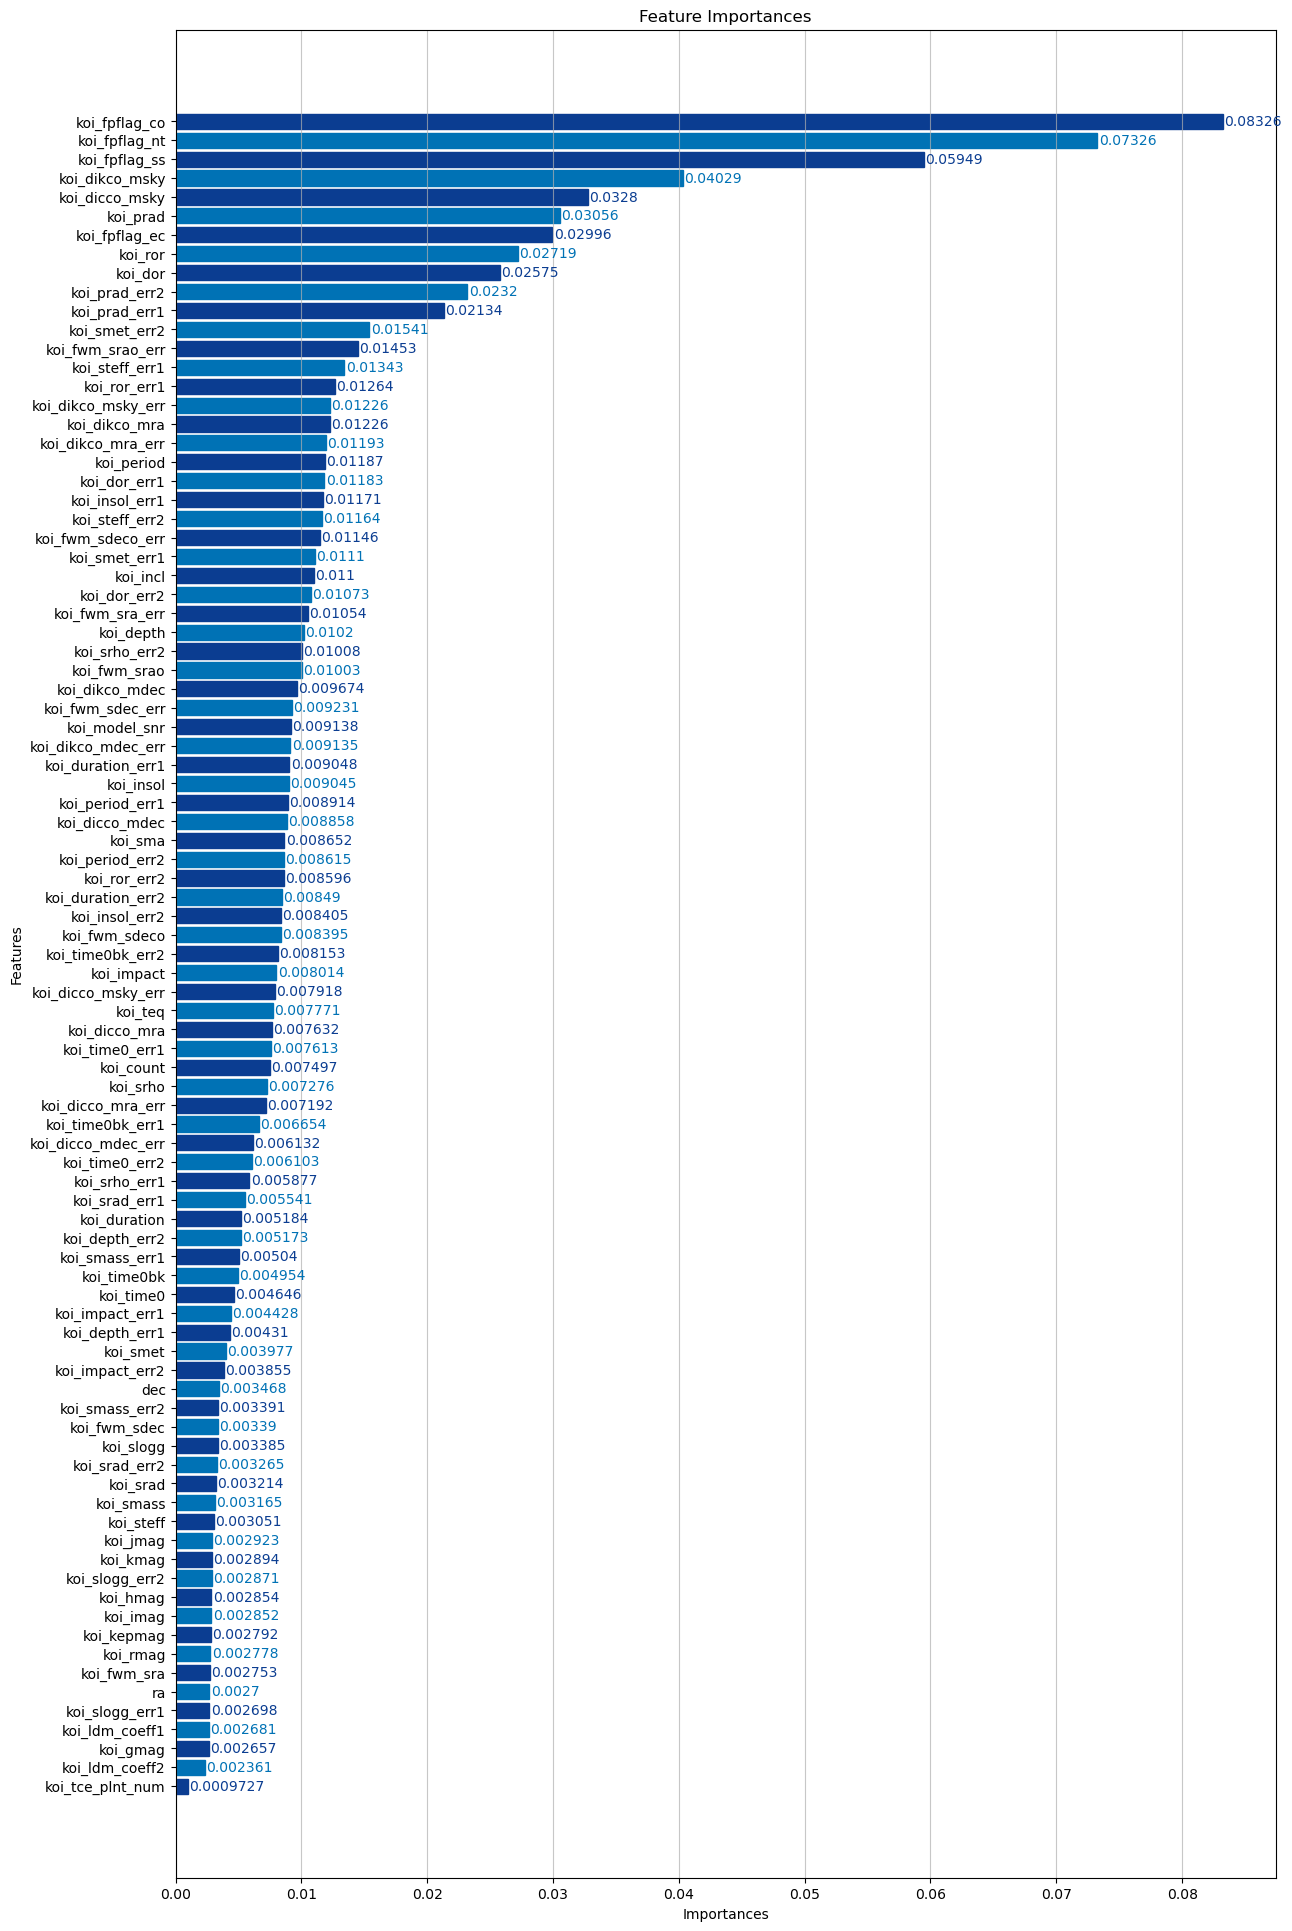

In [33]:
plot_feature_importances(X_train=X_train, feature_importances=model.feature_importances_)

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Decision Tree
dt_params = {'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10, 11]}
dt_classifier = DecisionTreeClassifier()
dt_grid_search = GridSearchCV(dt_classifier, dt_params, cv=5, n_jobs=N_JOBS, verbose=2)
dt_grid_search.fit(X_train, y_train)

# K-Nearest Neighbors
knn_params = {'n_neighbors': [3, 5, 7, 11, 15, 33]}
knn_classifier = KNeighborsClassifier(n_jobs=N_JOBS)
knn_grid_search = GridSearchCV(knn_classifier, knn_params, cv=5, n_jobs=N_JOBS, verbose=2)
knn_grid_search.fit(X_train, y_train)

# Gradient Boosting
gb_params = {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2, 0.001, 0.4]}
gb_classifier = GradientBoostingClassifier()
gb_grid_search = GridSearchCV(gb_classifier, gb_params, cv=5, n_jobs=N_JOBS, verbose=2)
gb_grid_search.fit(X_train, y_train)

# Print the best parameters for each classifier
print("Best parameters for Decision Tree:", dt_grid_search.best_params_)
print("Best parameters for K-Nearest Neighbors:", knn_grid_search.best_params_)
print("Best parameters for Gradient Boosting:", gb_grid_search.best_params_)

# Make predictions on the test set for each classifier
dt_predictions = dt_grid_search.predict(X_test)
knn_predictions = knn_grid_search.predict(X_test)
gb_predictions = gb_grid_search.predict(X_test)

# Evaluate accuracy for each classifier
dt_accuracy = accuracy_score(y_test, dt_predictions)
knn_accuracy = accuracy_score(y_test, knn_predictions)
gb_accuracy = accuracy_score(y_test, gb_predictions)

print("Accuracy for Decision Tree:", dt_accuracy)
print("Accuracy for K-Nearest Neighbors:", knn_accuracy)
print("Accuracy for Gradient Boosting:", gb_accuracy)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.3s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.4s
[CV] END ...............max_depth=None, min_samples_split=10; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.4s
[CV] END ...............max_depth=None, min_samples_split=10; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.4s
[CV] END ...............max_depth=None, min_samples_split=11; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=5; total time=   0.4s
[CV] END ................max_depth=None, min_samples_split=2; total time=   0.5s
[CV] END ...............max_depth=None, min_samp

In [35]:
# Best parameters for Decision Tree: {'max_depth': 30, 'min_samples_split': 11}
# Best parameters for K-Nearest Neighbors: {'n_neighbors': 7}
# Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'n_estimators': 500}
# Accuracy for Decision Tree: 0.9965156794425087
# Accuracy for K-Nearest Neighbors: 0.9088269454123112
# Accuracy for Gradient Boosting: 0.9976771196283392